In [1]:
# This is the template for the submission. You can develop your algorithm in a regular Python script and copy the code here for submission.

# TEAM NAME ON KAGGLE
# "EXAMPLE_GROUP"

# GROUP NUMBER
# "group_XX"

# TEAM MEMBERS (E-MAIL, LEGI, KAGGLE USERNAME):
# "examplestudent1@ethz.ch", "12-345-678", "eXampl3stdNtone" 
# "examplestudent2@ethz.ch", "12-345-679", "xXexamplestudent2Xx"
# "examplestudent3@ethz.ch", "12-345-670", "mhealth_student_98"

In [2]:
from os import listdir
from os.path import isfile, join
import re

import pandas as pd
import numpy as np

# You may change the mhealth_activity module but your algorithm must support the original version
from mhealth_activity import Recording
import matplotlib.pyplot as plt

# For interactive graphs
# %matplotlib widget

In [ ]:
'''
Algorithm Description:
The algorithm is based on the following steps:
1) First we decide if there is cycling in the actiities, if there is we try to cut the cycling part based on the path taken:
    path 0: dont cut anything
    path 1: cut first third
    path 2: cut last third
    path 3: cut first third
    path 4: cut last third
2) We run an average filter with 0.31s window size to smooth the data
3) We use scipys find_peaks to find the peaks in the data with threshold at 1.1
4) Steps are len(peaks) TODO: maybe higher threshold and double steps

'''

In [12]:
# Get the path for all test traces
'''
dir_traces_test = 'data/test'
filenames_test = [join(dir_traces_test, f) for f in listdir(dir_traces_test) if isfile(join(dir_traces_test, f))]
filenames_test.sort()
recordings_test = []
for fn in filenames_test:
    rec = Recording(fn)
    match = re.search(r'(\d{3})\.pkl$', fn)
    if match:
        id = int(match.group(1))
        rec.id = id
    else:
        raise ValueError(f'Filename {fn} does not match expected format')
    recordings_test.append(rec)
'''
    
    
dir_traces_train = 'data/train'
filenames_train = [join(dir_traces_train, f) for f in listdir(dir_traces_train) if isfile(join(dir_traces_train, f))]
filenames_train.sort()
axs = []
ays = []
azs = []
gxs = []
gys = []
gzs = []
paxs = []
pays = []
pazs = []
steps = []
sample_rates_phone = []
sample_rates_watch = []
alts = []
path_idxs = []
activities = []
for fn in filenames_train:
    rec = Recording(fn)
    axs.append(rec.data['ax'].values)
    ays.append(rec.data['ay'].values)
    azs.append(rec.data['az'].values)
    gxs.append(rec.data['gx'].values)
    gys.append(rec.data['gy'].values)
    gzs.append(rec.data['gz'].values)
    paxs.append(rec.data['phone_ax'].values)
    pays.append(rec.data['phone_ay'].values)
    pazs.append(rec.data['phone_az'].values)
    steps.append(rec.labels['step_count'])
    sample_rates_phone.append(rec.data['phone_ax'].samplerate)
    sample_rates_watch.append(rec.data['ax'].samplerate)
    alts.append(rec.data['altitude'].values)
    path_idxs.append(rec.labels['path_idx'])
    activities.append(rec.labels['activities'])

In [4]:
from scipy.signal import argrelextrema, find_peaks
def centered_moving_average(data, window_size):
    ret = np.cumsum(data, dtype=float)
    ret[window_size:] = ret[window_size:] - ret[:-window_size]
    return ret[window_size - 1:] / window_size
def plot_array(arr):
    plt.figure(figsize=(25, 3))
    plt.plot(arr)
    plt.show()

def windowed_peak_detection(data, window_size):
    # Initialize an empty list to store the peaks
    peaks = []

    # Divide the data into windows
    for i in range(0, len(data), window_size):
        window = data[i:i + window_size]

        # Compute the relative maxima of the window
        window_peaks = argrelextrema(window, np.greater)

        # Add the indices of the peaks to the list
        peaks.extend(window_peaks[0] + i)

    return np.array(peaks)

def get_steps_from_peaks(data, peaks, threshold=1.25):
    steps=0
    for peak in peaks:
        if data[peak]>threshold:
            steps+=1
    return steps

def get_steps(data, window_size=80, threshold=1.25):
    peaks, _ = find_peaks(data, height=1.25, distance=80)
    steps = get_steps_from_peaks(data, peaks, threshold)
    return steps

with open('indices.txt', 'r') as f:
    indices = [line.rstrip() for line in f]
    

def pad_arrays(arr_list):
    max_len = max(len(arr) for arr in arr_list)
    return [np.pad(arr, (0, max_len - len(arr)), 'constant') for arr in arr_list]

In [15]:

def save_arrays(X, y, X_filename='X.npy', y_filename='y.npy'):
    np.save(X_filename, X)
    np.save(y_filename, y)

def load_arrays(X_filename='X.npy', y_filename='y.npy'):
    X = np.load(X_filename)
    y = np.load(y_filename)
    return X, y

type(path_idxs[0])

int

In [22]:
accel_mags_watch = []
accel_mags_phone = []
steps_num = []
samp_rates = []
for idx in indices:
    mag = np.sqrt(axs[int(idx)]**2 + ays[int(idx)]**2 + azs[int(idx)]**2)
    accel_mags_watch.append(mag)
    same_len_list = pad_arrays([paxs[int(idx)], pays[int(idx)], pazs[int(idx)]])
    mag = np.sqrt(same_len_list[0]**2 + same_len_list[1]**2 + same_len_list[2]**2)
    accel_mags_phone.append(mag/9.81)
    steps_num.append(steps[int(idx)])
    samp_rates.append(int(sample_rates_phone[int(idx)]))
max_len = 0
idx = -1
for i,mag in enumerate(accel_mags_phone):
    if len(mag) > max_len:
        max_len = len(mag)
        idx = i

new_data = []
for i,mag in enumerate(accel_mags_watch):
    path_idx = path_idxs[int(indices[i])]
    act = activities[int(indices[i])]
    if 3 in act:
        if path_idx == 0:
            new_data.append(mag)
        elif path_idx == 2 or path_idx == 4:
            #discard last third
            end_idx = int(len(mag)*0.666)
            new_data.append(mag[:end_idx])
        elif path_idx == 1 or path_idx == 3:
            #discard first third
            start_idx = int(len(mag)*0.333)
            new_data.append(mag[start_idx:])
    else:
        new_data.append(mag)
    

X,y = load_arrays()

save_arrays(X, y, 'X.npy', 'y.npy')

type(samp_rates[0])



int

In [ ]:
rec = Recording(filenames_train[0])
fnshuff = np.random.permutation(filenames_train)
for fn in fnshuff:
    fn = filenames_train[14]
    rec = Recording(fn)
    if not (rec.labels['step_count'] == None):
        break
rec.data.keys()

dict_keys(['phone_my', 'phone_orientationz', 'gz', 'latitude', 'phone_gy', 'phone_mz', 'phone_orientationy', 'phone_rotz', 'gx', 'phone_lay', 'phone_rotx', 'timestamp', 'bearing', 'phone_mx', 'phone_gx', 'longitude', 'my', 'altitude', 'phone_roty', 'phone_rotm', 'packetNumber', 'ax', 'phone_ax', 'phone_gravz', 'phone_gz', 'mz', 'mx', 'phone_laz', 'phone_lax', 'speed', 'az', 'phone_orientationx', 'temperature', 'phone_az', 'phone_ay', 'ay', 'phone_gravy', 'phone_gravx', 'gy'])

In [28]:
cycling_data = 0
for i in range(len(activities)):
    if 3 in activities[i]:
        cycling_data += 1
cycling_data / len(activities)

0.14646464646464646

In [25]:
len(accel_mags_watch)

33

index: 0
{'path_idx': 2, 'activities': [0, 1, 3], 'step_count': 288, 'watch_loc': 2}
pred: 349 
true: 288


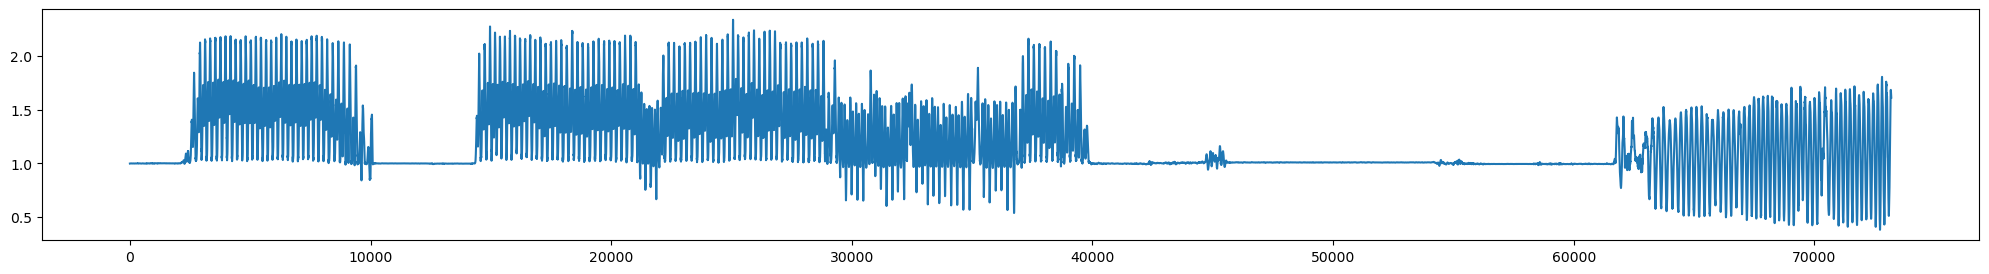

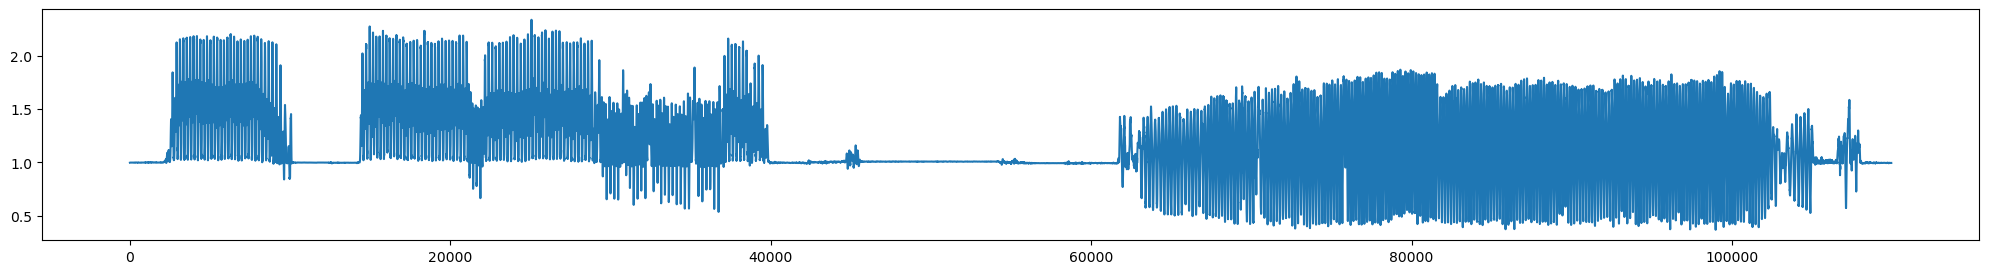

index: 1
{'path_idx': 2, 'activities': [0, 1, 3], 'step_count': 286, 'watch_loc': 2}
pred: 352 
true: 286


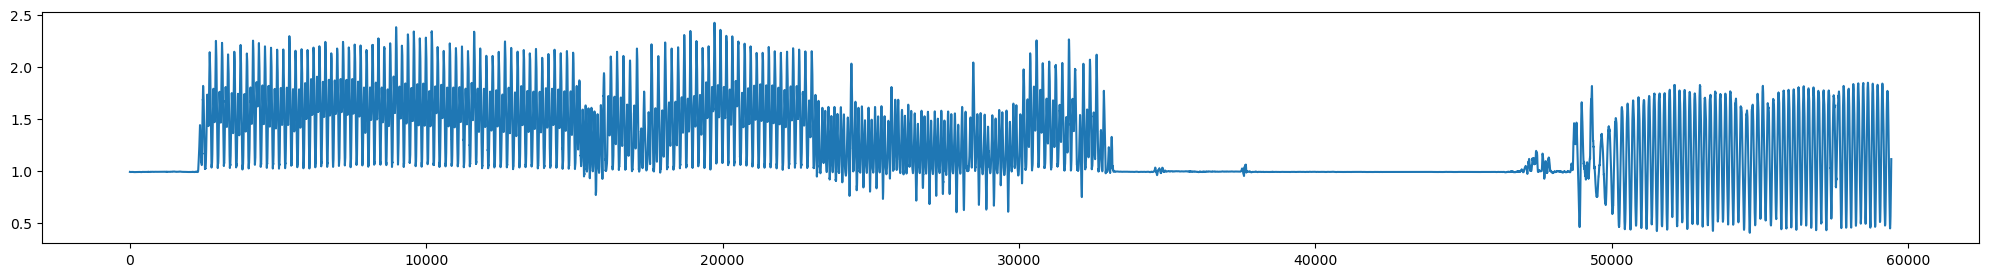

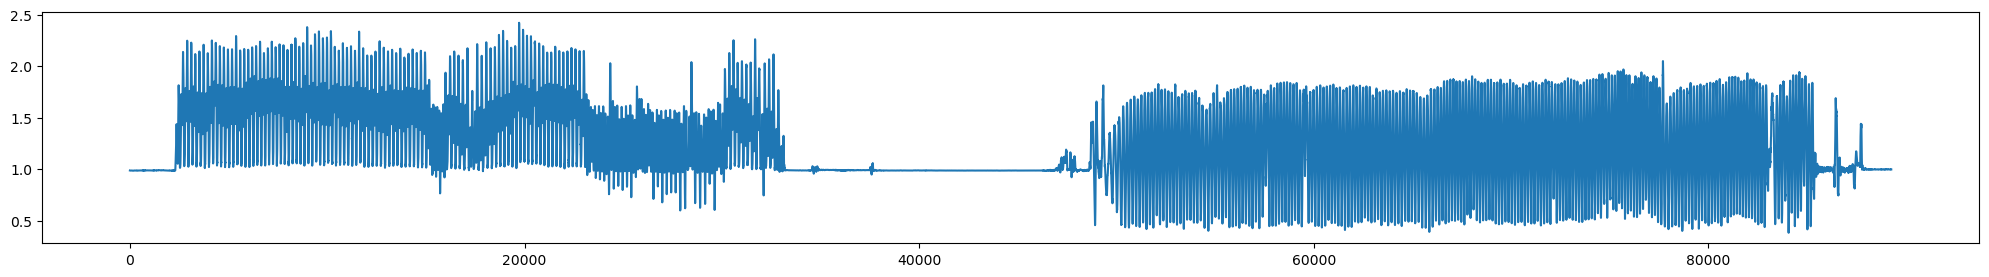

index: 2
{'path_idx': 4, 'activities': [0, 1, 3], 'step_count': 179, 'watch_loc': 0}
pred: 266 
true: 179


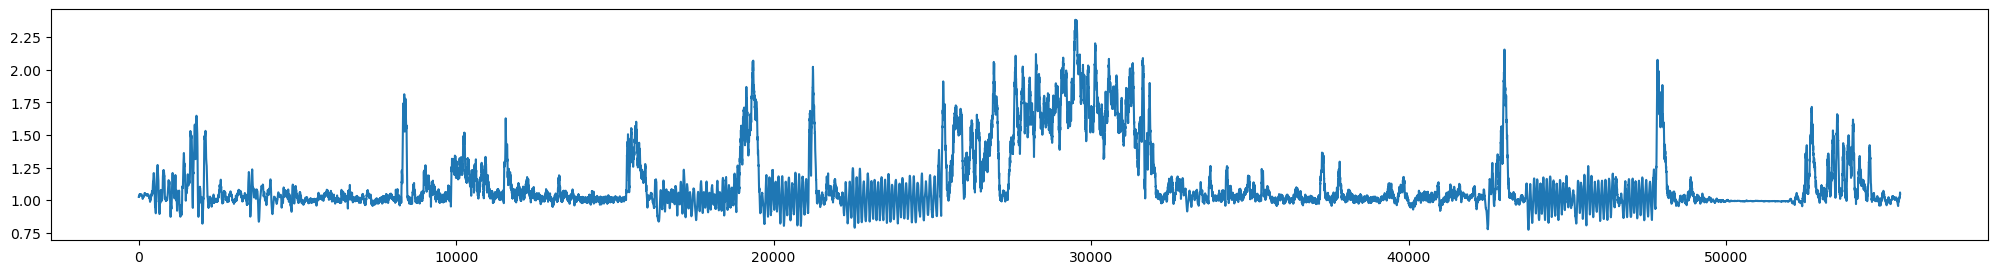

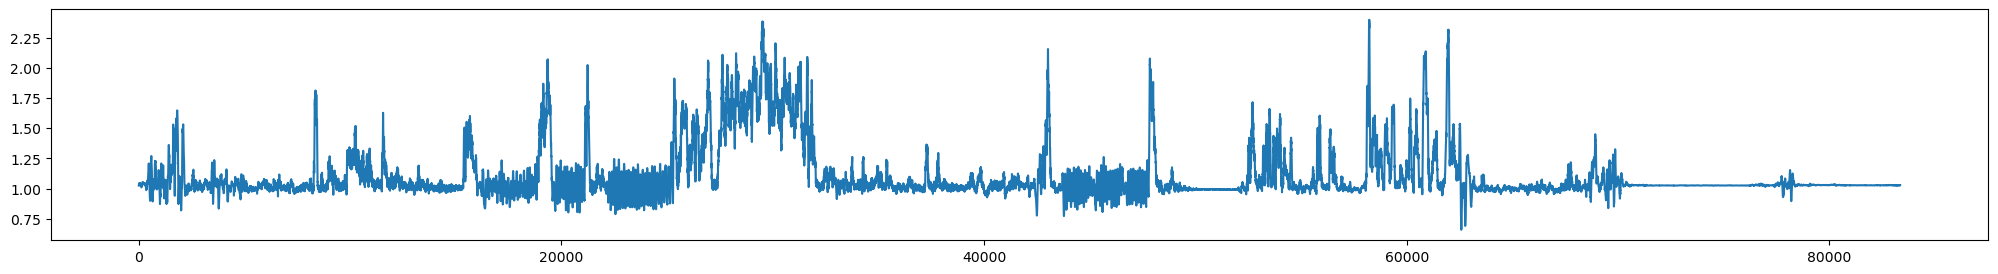

index: 3
{'path_idx': 4, 'activities': [1, 3], 'step_count': 255, 'watch_loc': 1}
pred: 191 
true: 255


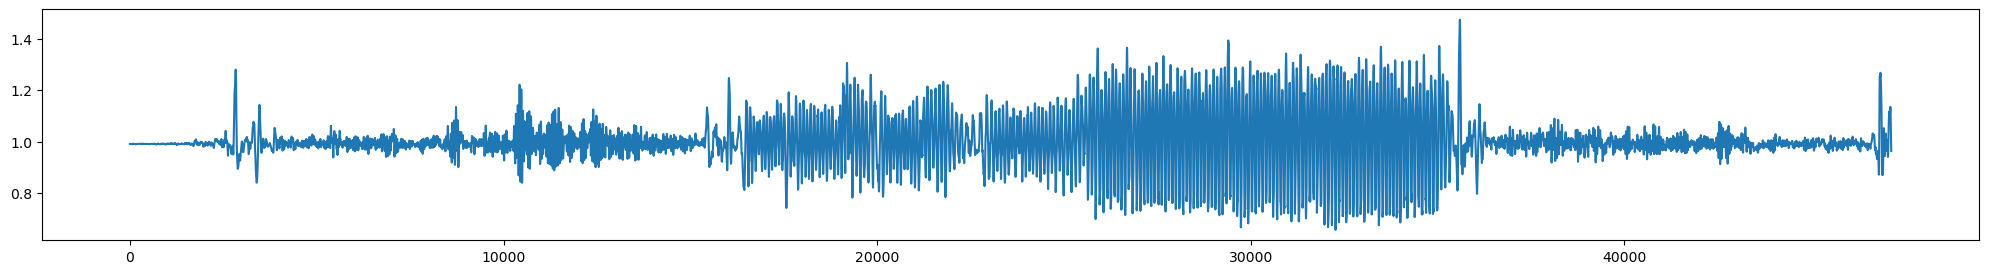

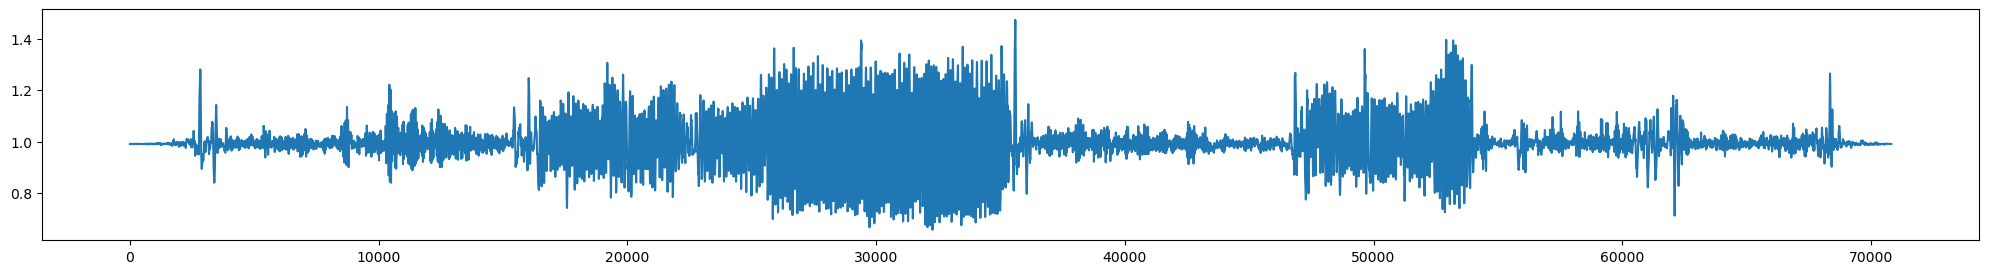

index: 4
{'path_idx': 3, 'activities': [0, 1, 3], 'step_count': 266, 'watch_loc': 1}
pred: 267 
true: 266


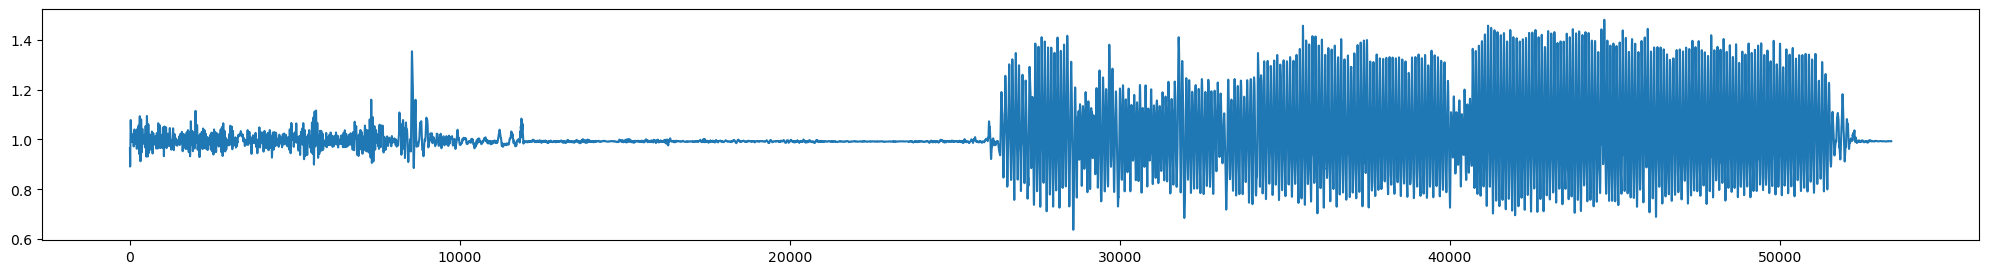

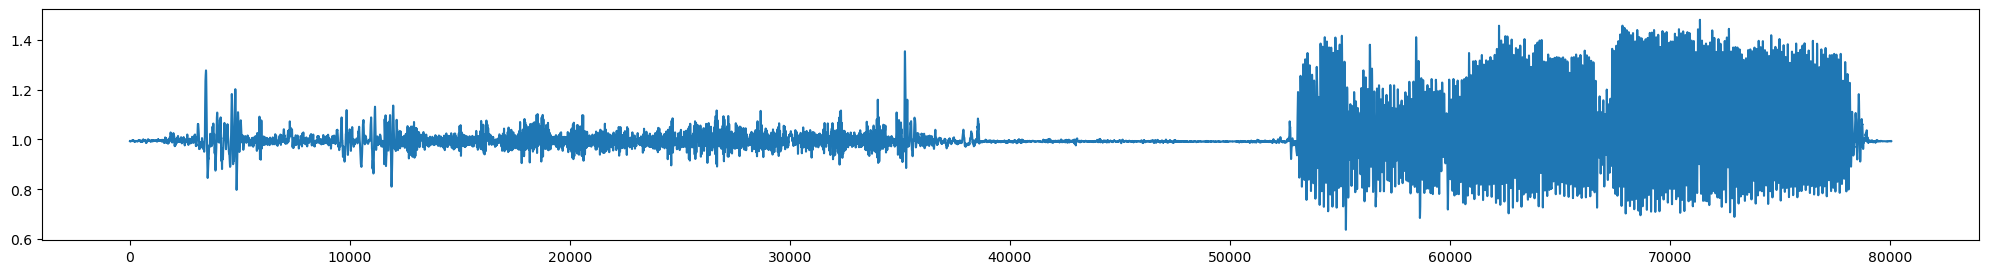

index: 5
{'path_idx': 1, 'activities': [1, 2], 'step_count': 960, 'watch_loc': 0}
pred: 826 
true: 960


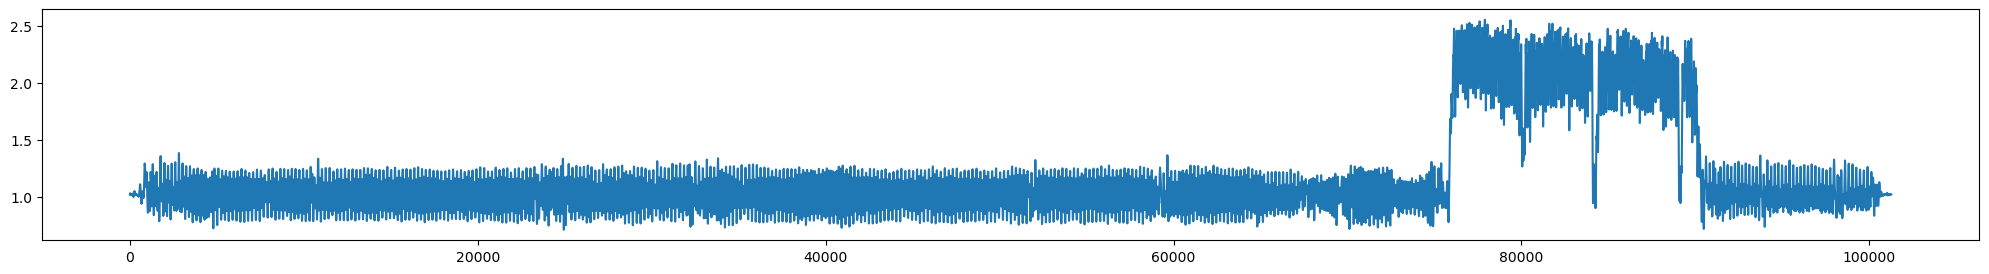

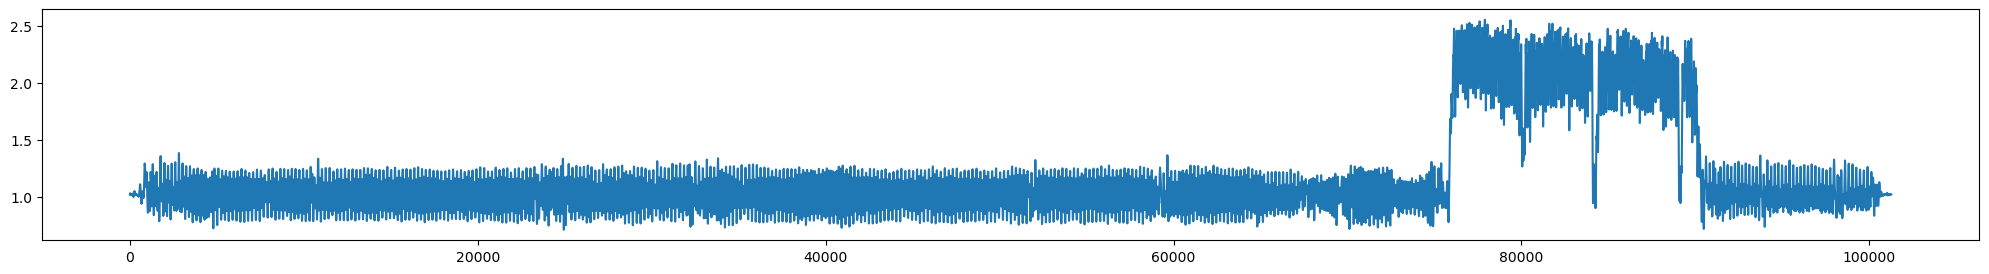

index: 7
{'path_idx': 1, 'activities': [1, 3], 'step_count': 154, 'watch_loc': 1}
pred: 171 
true: 154


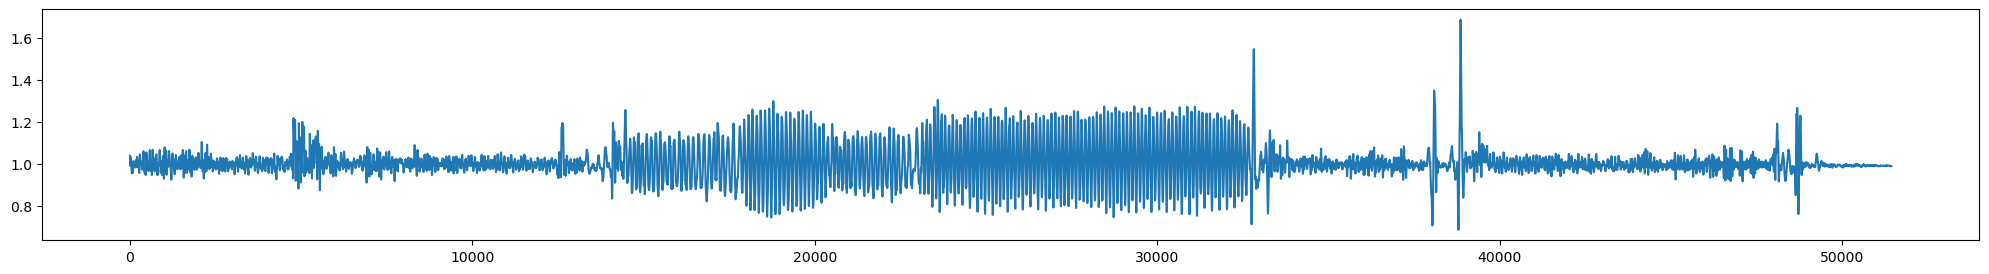

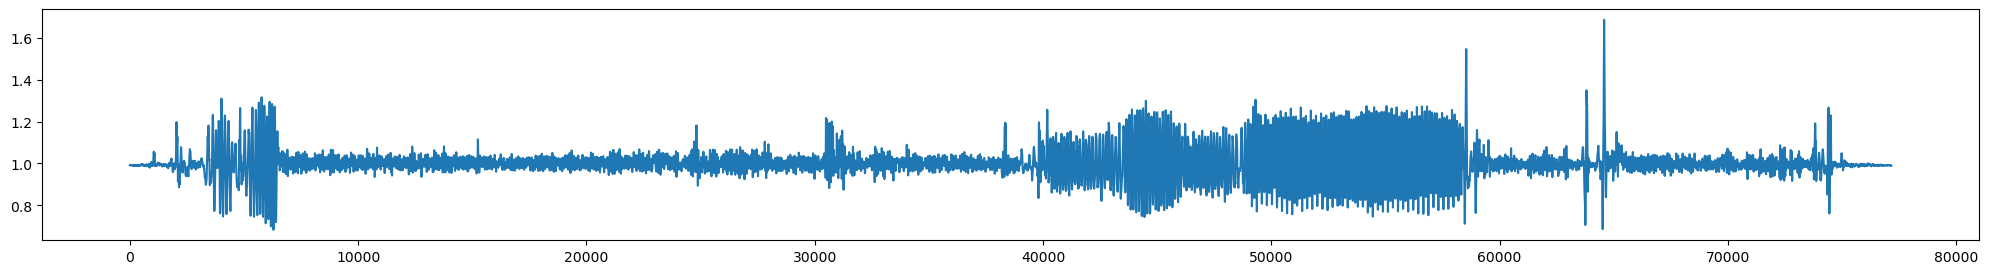

index: 9
{'path_idx': 3, 'activities': [0, 1, 3], 'step_count': 287, 'watch_loc': 0}
pred: 306 
true: 287


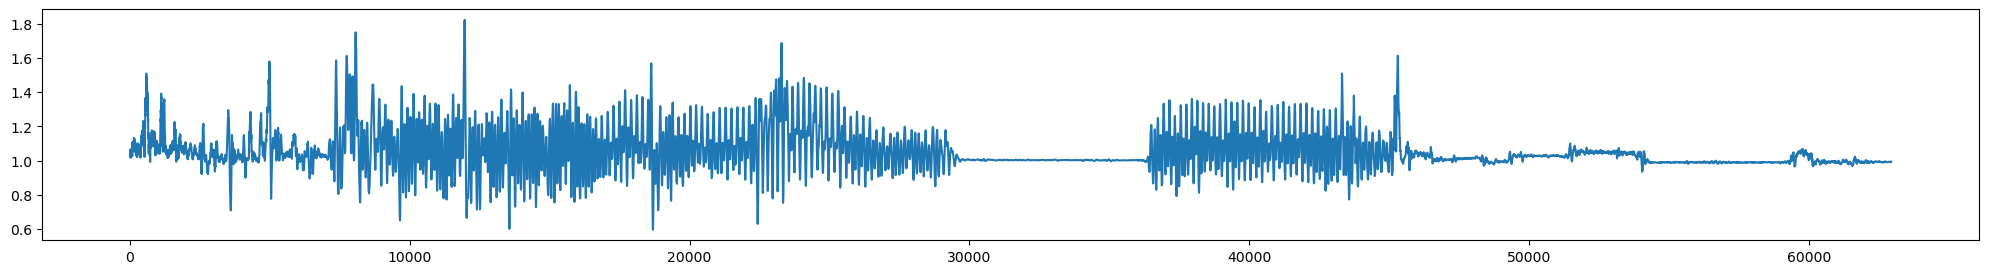

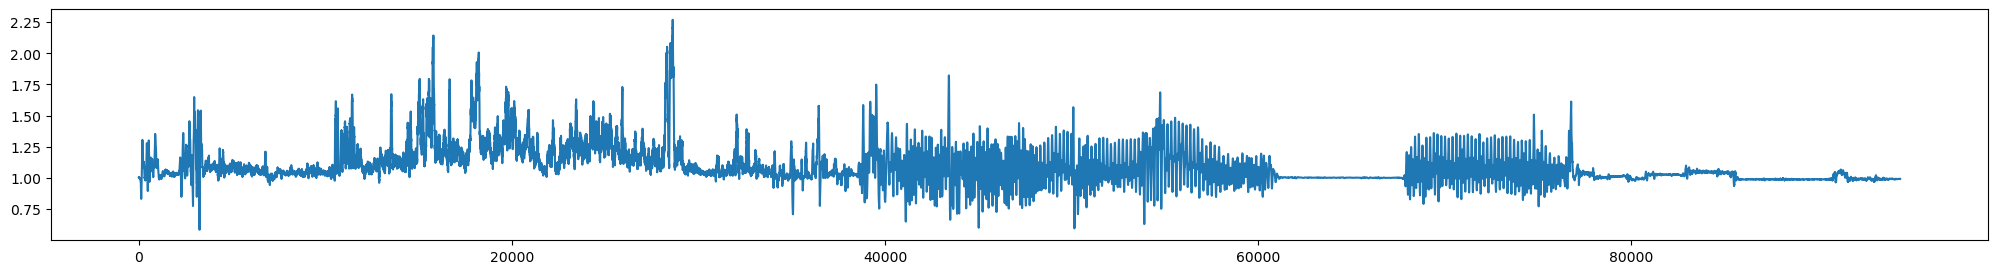

index: 10
{'path_idx': 4, 'activities': [1], 'step_count': 1023, 'watch_loc': 1}
pred: 1016 
true: 1023


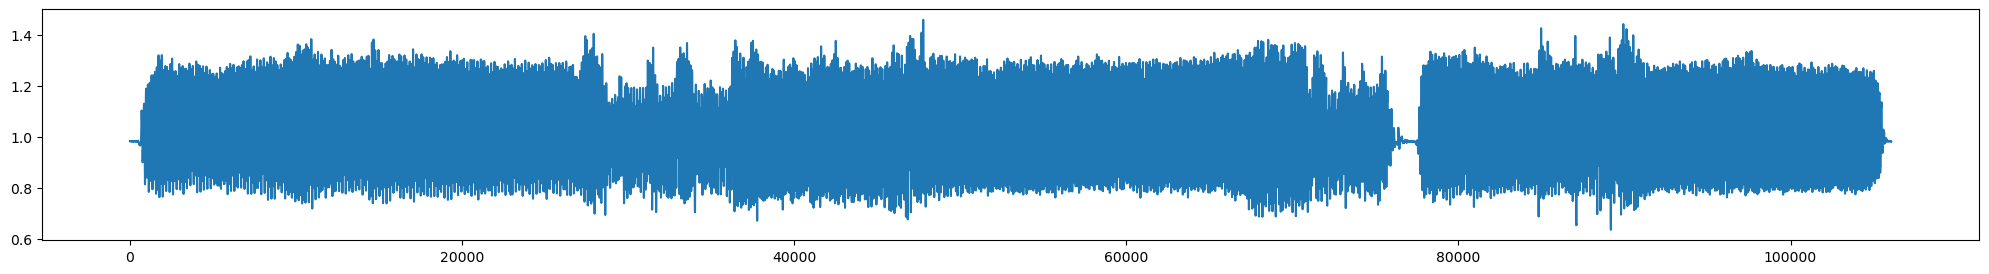

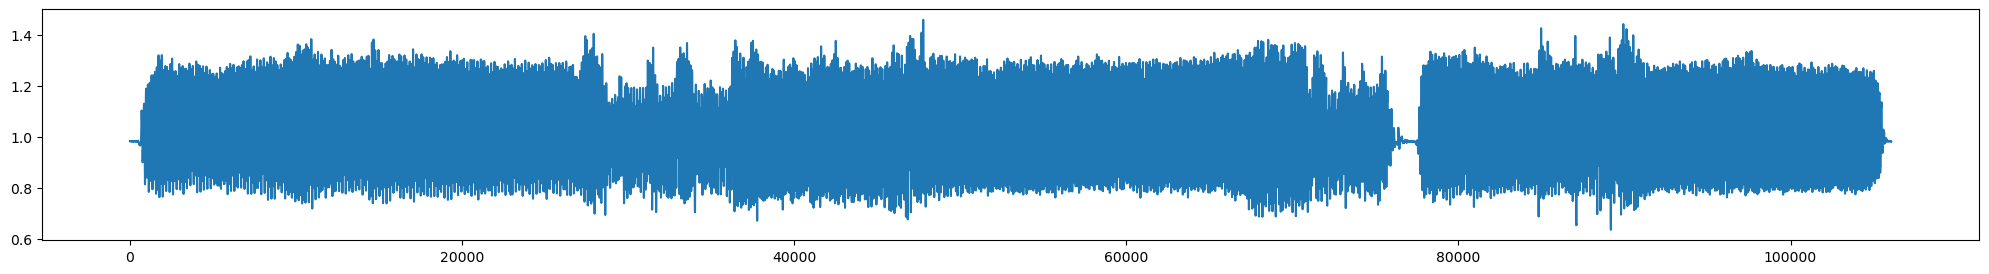

index: 11
{'path_idx': 4, 'activities': [1, 3], 'step_count': 251, 'watch_loc': 0}
pred: 137 
true: 251


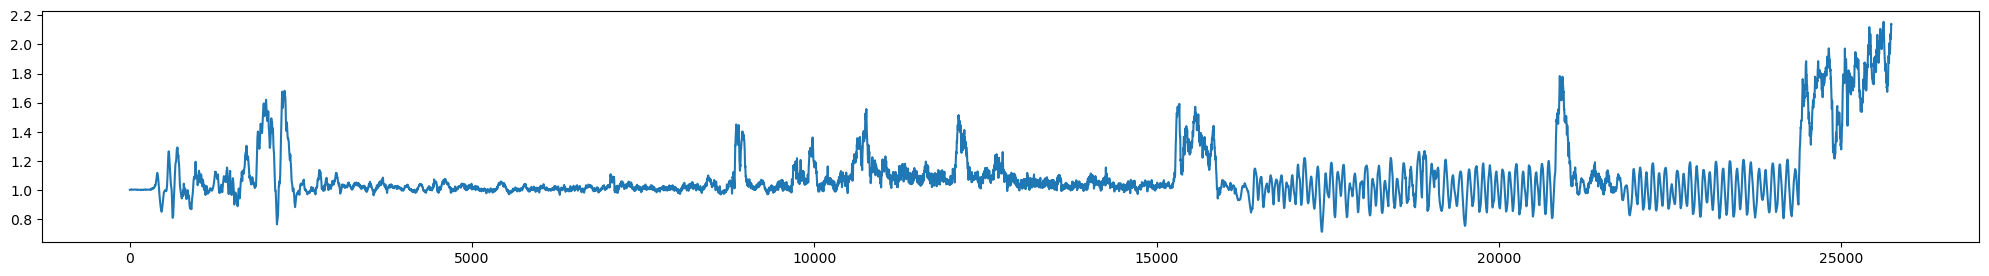

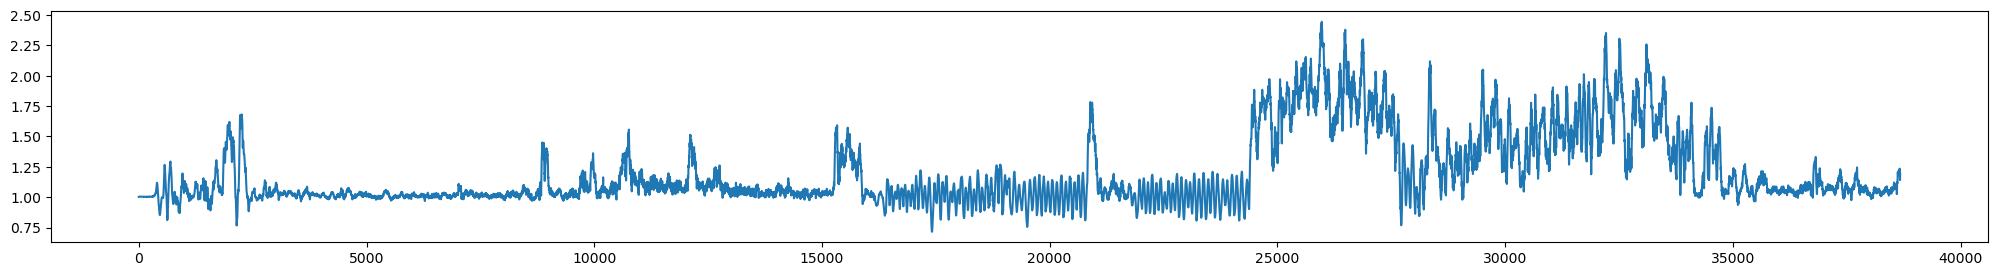

index: 13
{'path_idx': 2, 'activities': [1, 3], 'step_count': 172, 'watch_loc': 0}
pred: 173 
true: 172


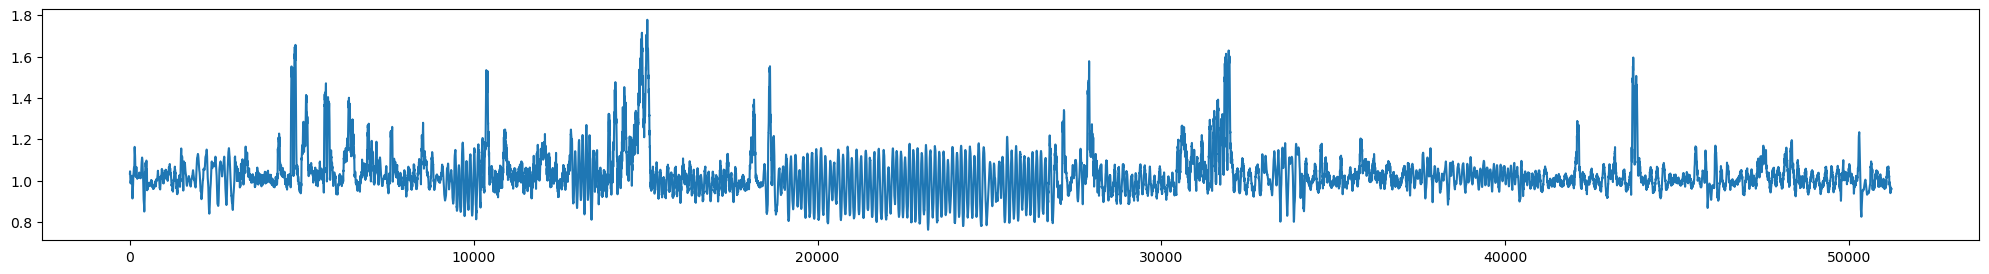

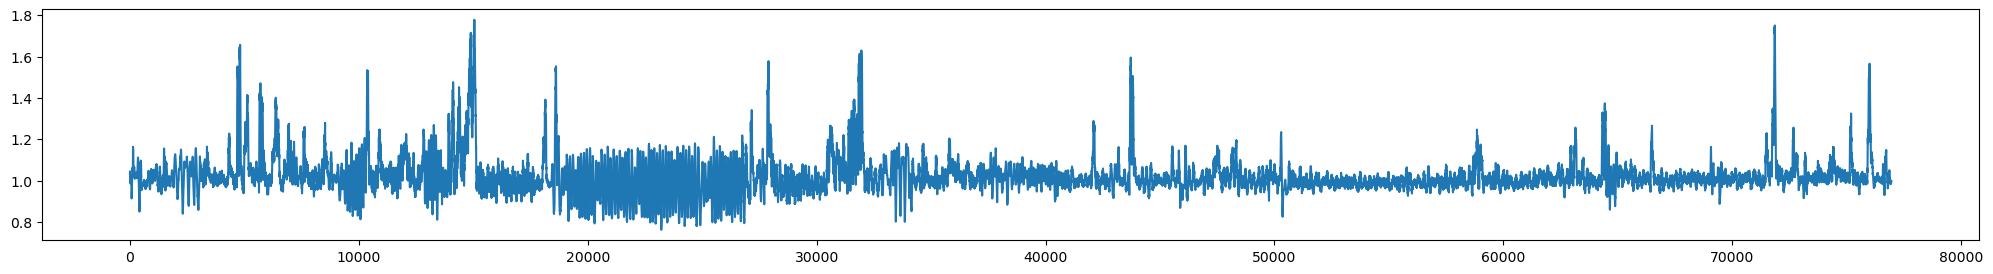

index: 14
{'path_idx': 2, 'activities': [0, 1, 3], 'step_count': 290, 'watch_loc': 0}
pred: 382 
true: 290


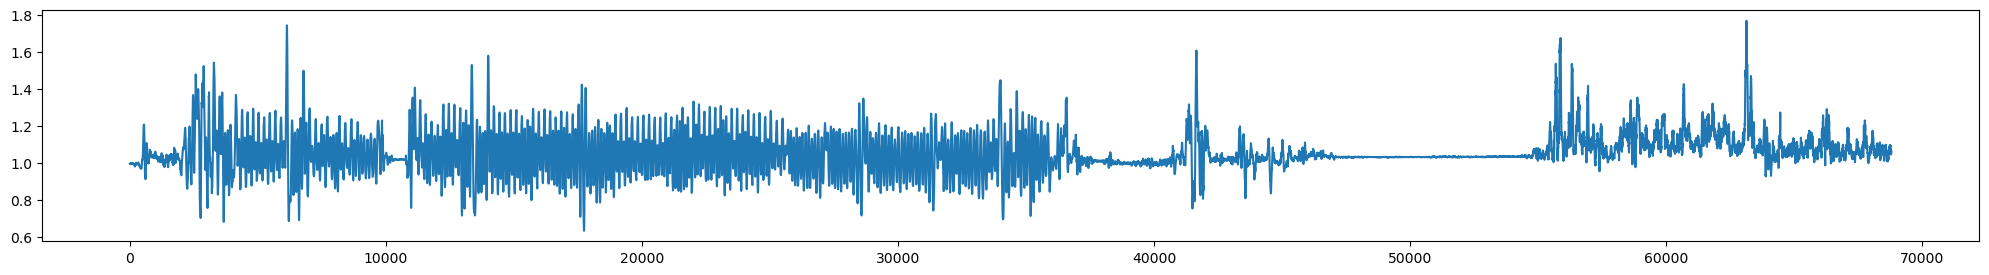

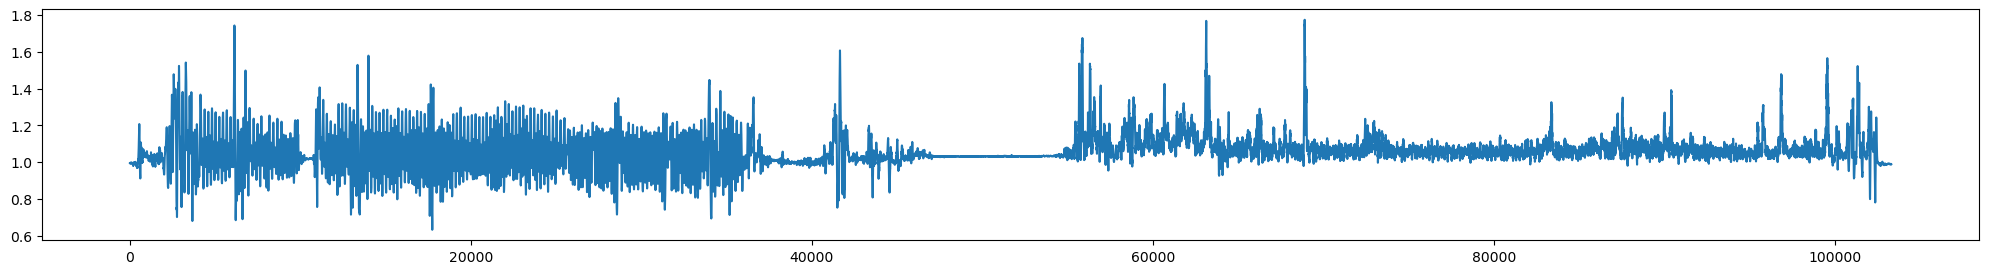

index: 15
{'path_idx': 1, 'activities': [1, 3], 'step_count': 147, 'watch_loc': 0}
pred: 218 
true: 147


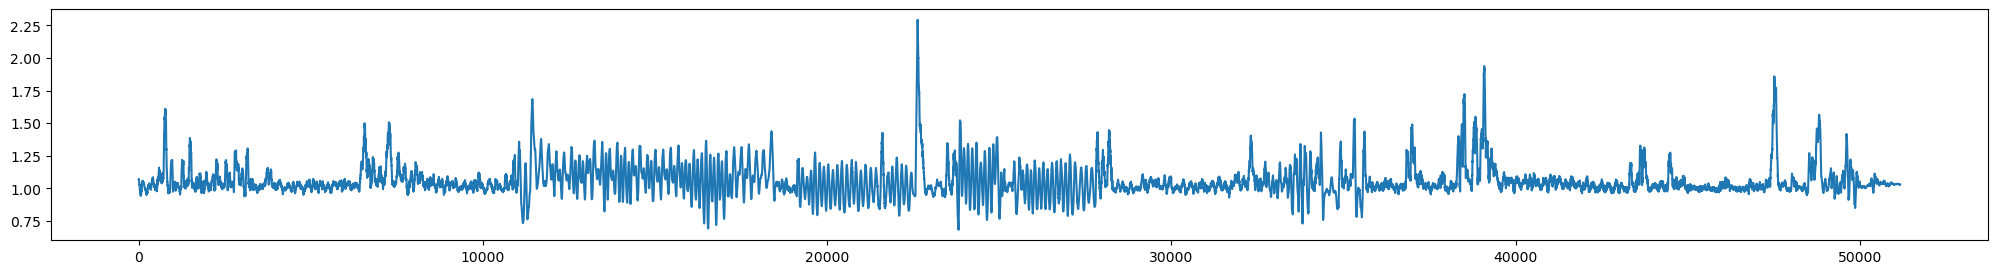

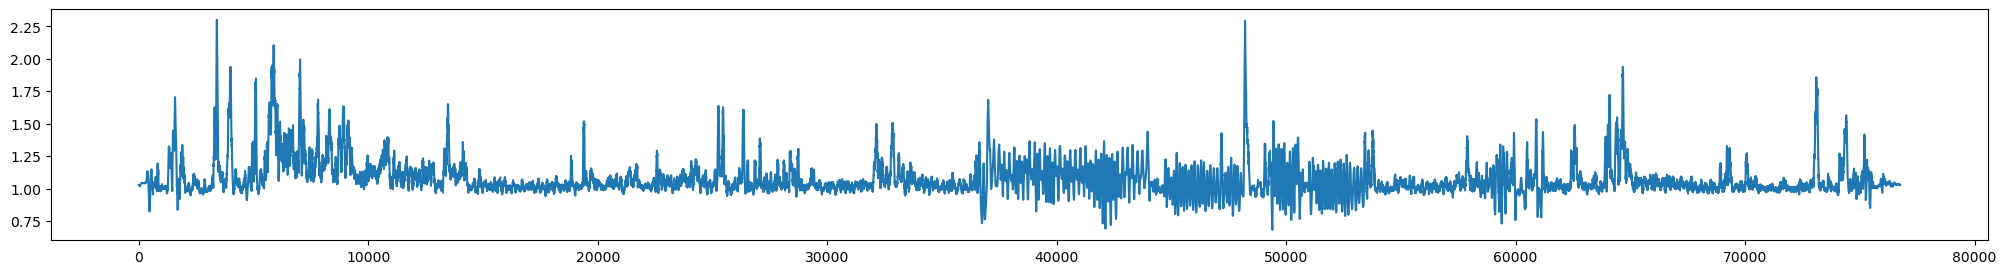

index: 16
{'path_idx': 3, 'activities': [1, 3], 'step_count': 281, 'watch_loc': 0}
pred: 295 
true: 281


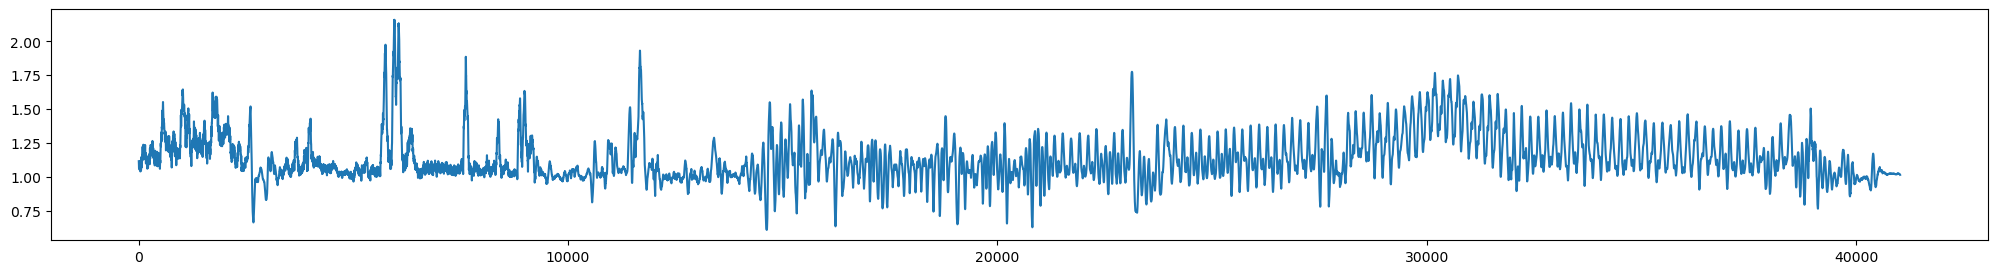

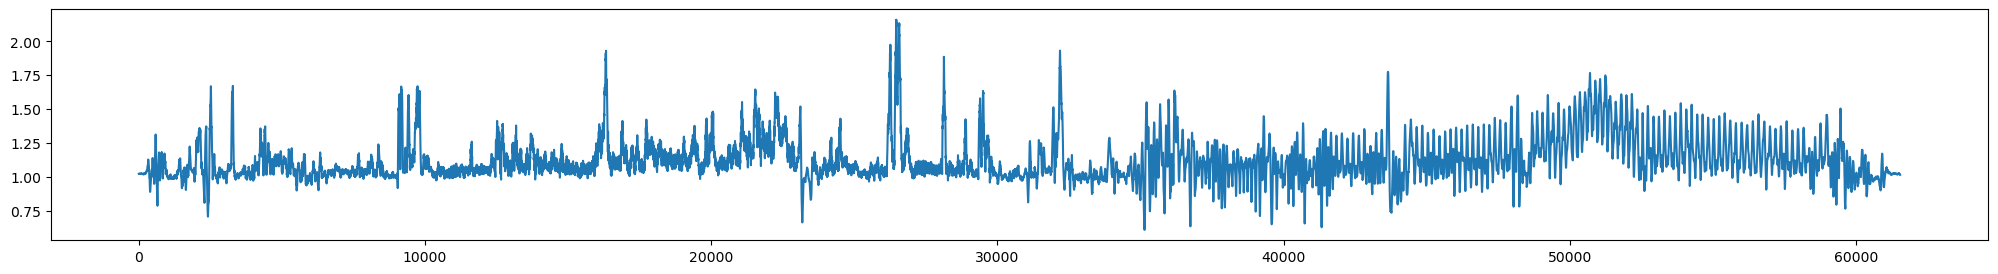

index: 17
{'path_idx': 2, 'activities': [1], 'step_count': 1021, 'watch_loc': 0}
pred: 999 
true: 1021


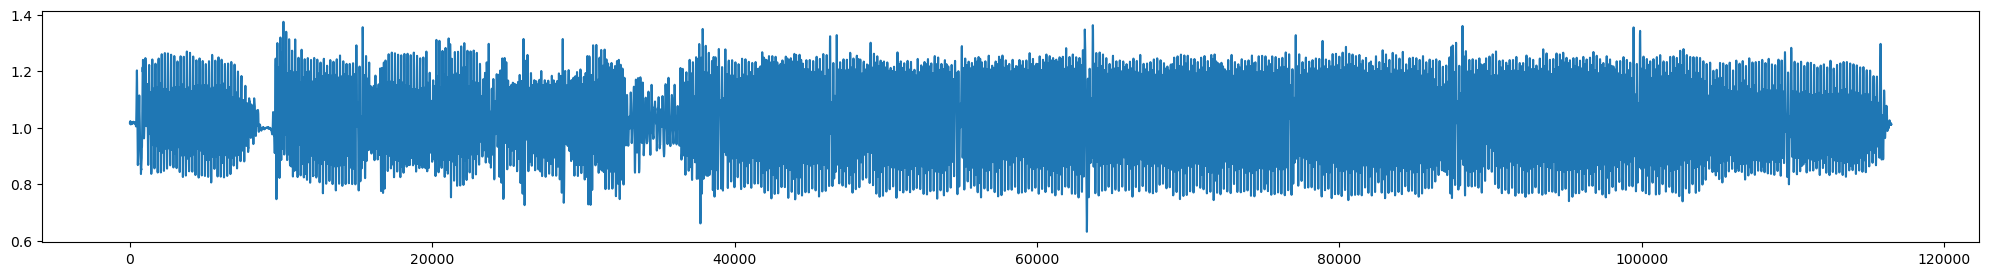

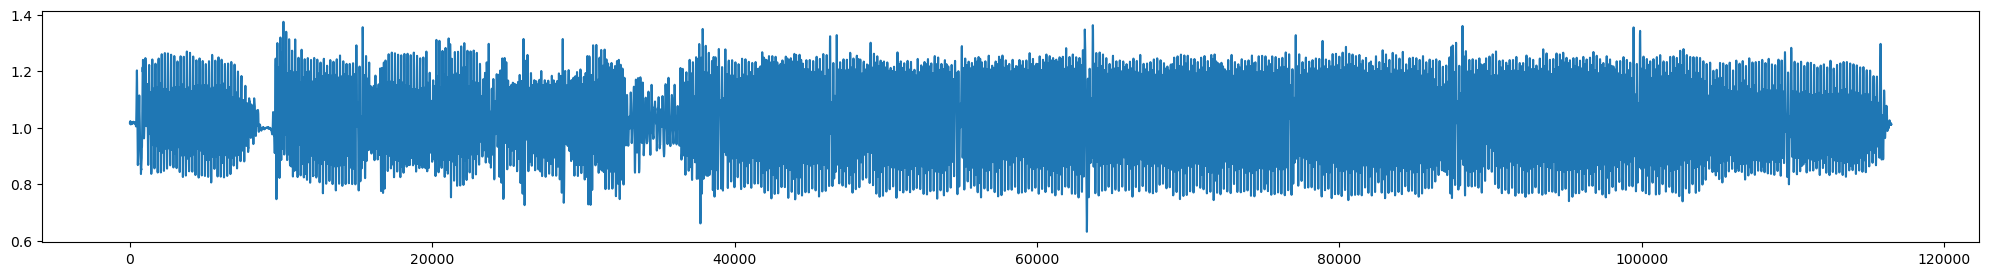

index: 18
{'path_idx': 4, 'activities': [1, 3], 'step_count': 168, 'watch_loc': 2}
pred: 240 
true: 168


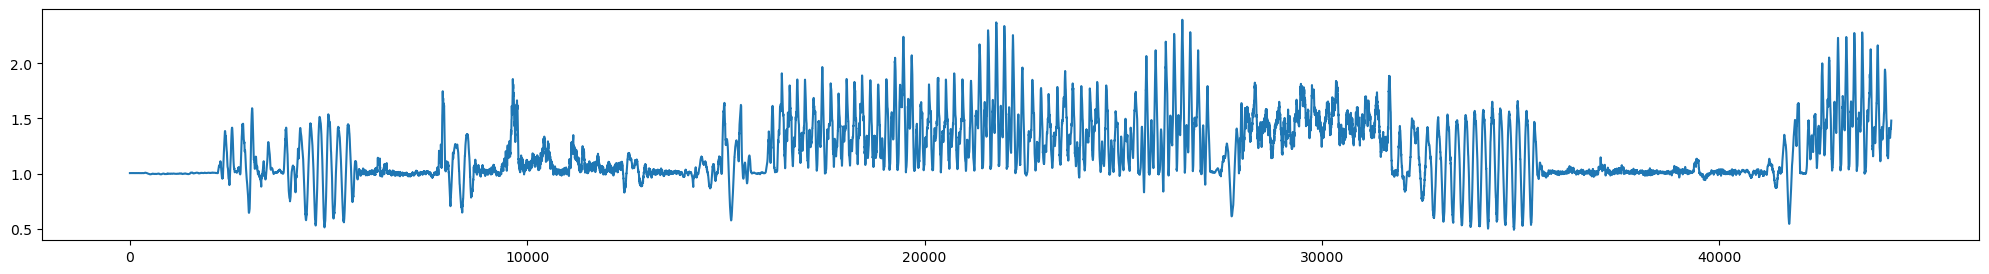

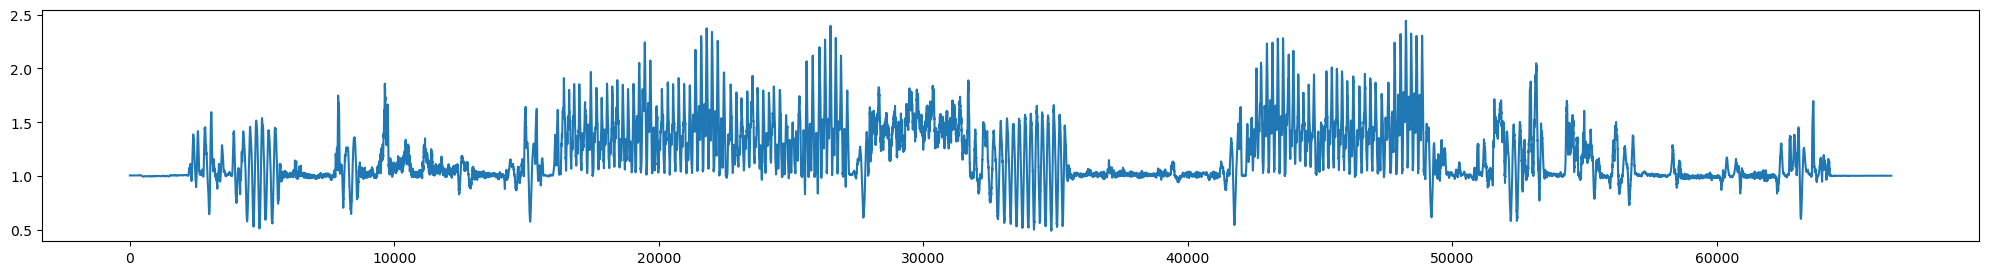

index: 19
{'path_idx': 4, 'activities': [1, 3], 'step_count': 168, 'watch_loc': 2}
pred: 228 
true: 168


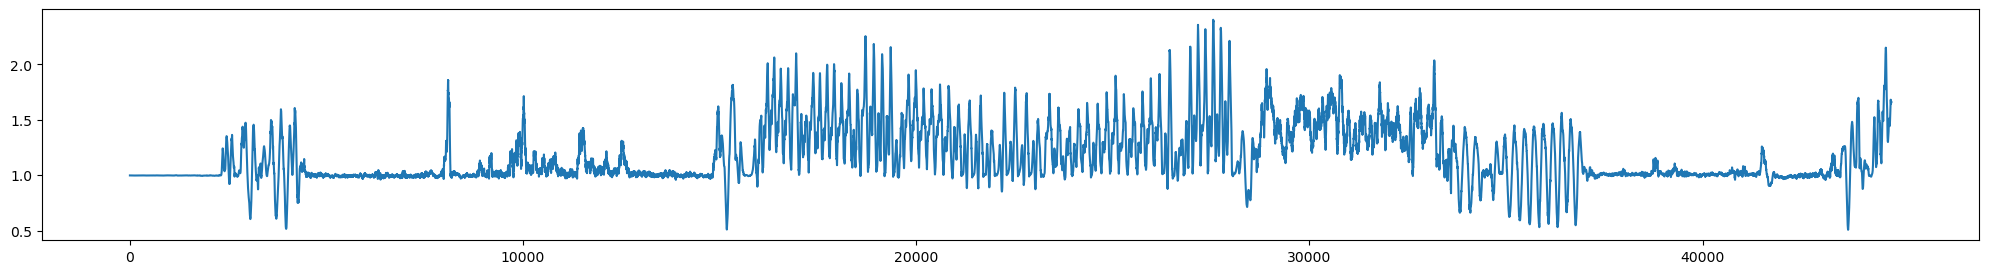

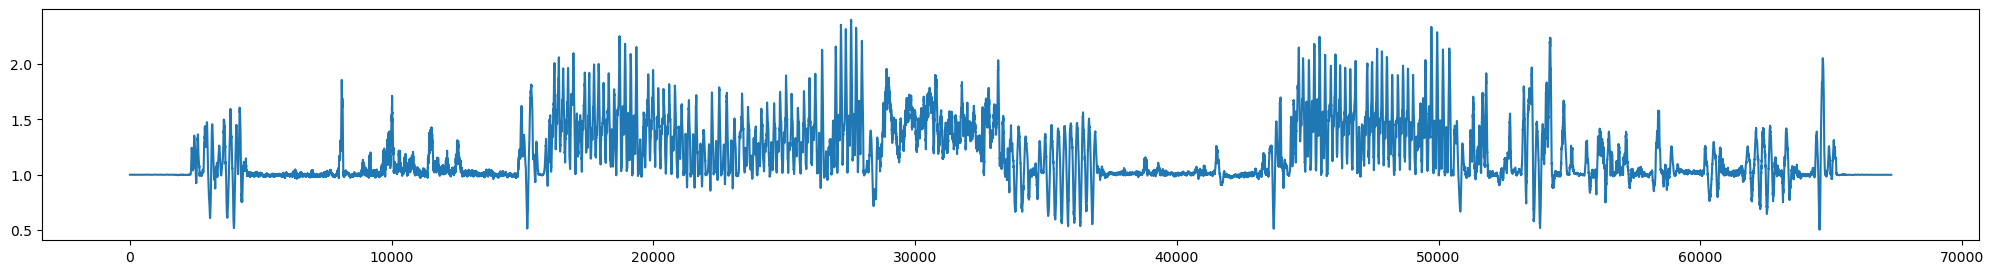

index: 20
{'path_idx': 3, 'activities': [1], 'step_count': 1018, 'watch_loc': 1}
pred: 1011 
true: 1018


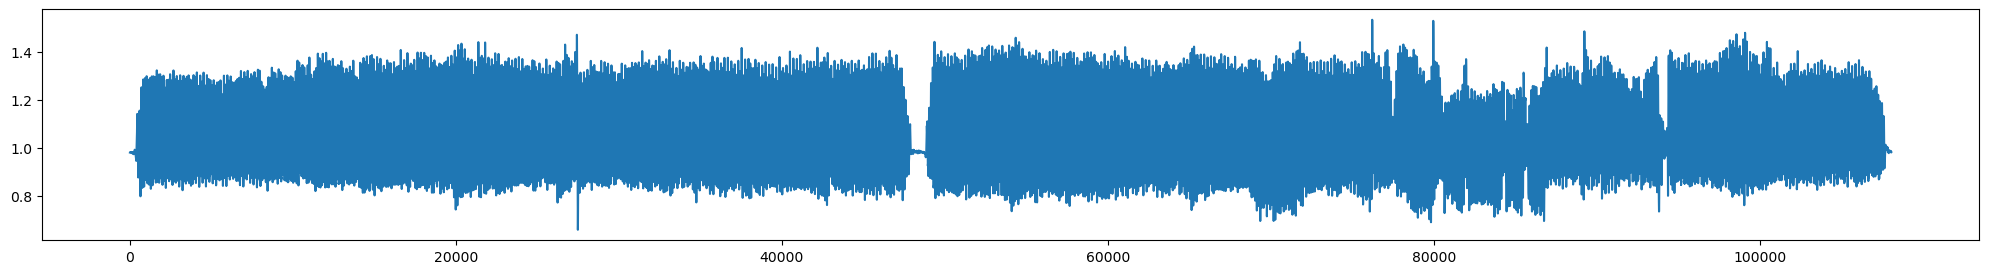

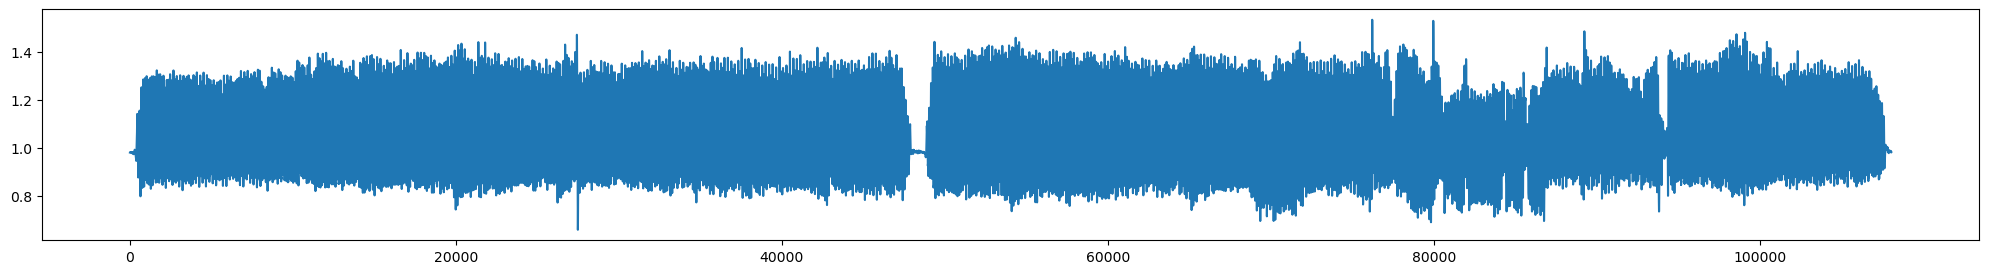

index: 21
{'path_idx': 2, 'activities': [1, 3], 'step_count': 268, 'watch_loc': 1}
pred: 253 
true: 268


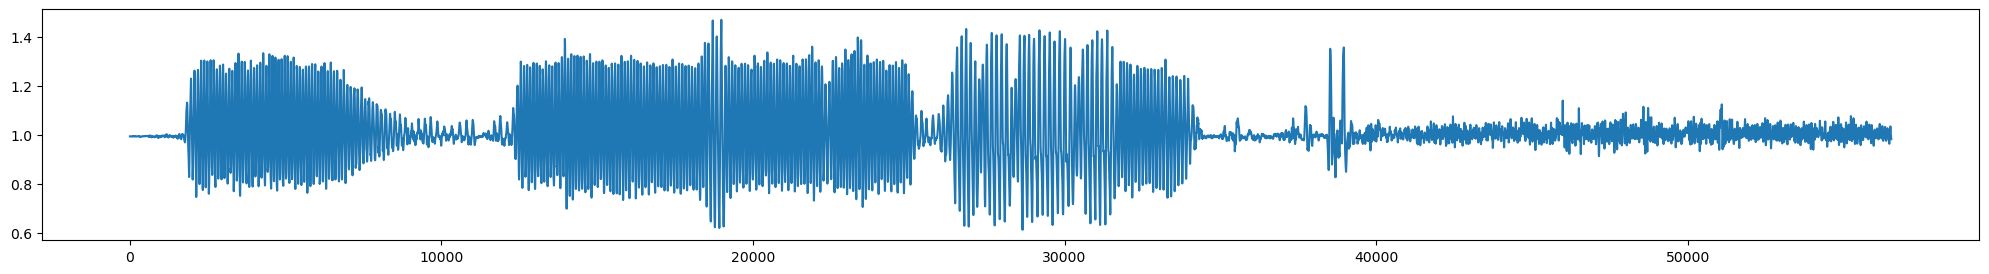

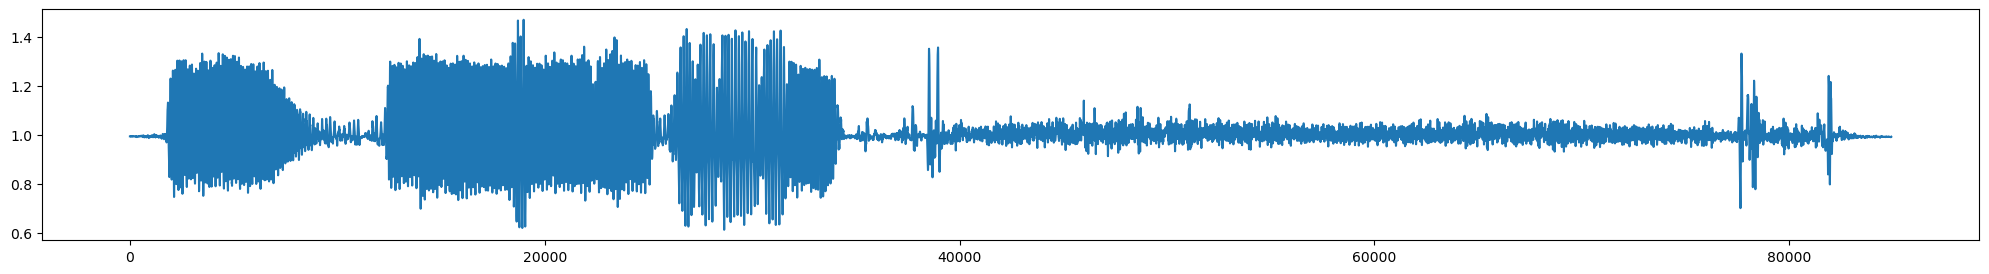

index: 22
{'path_idx': 4, 'activities': [1, 3], 'step_count': 245, 'watch_loc': 2}
pred: 280 
true: 245


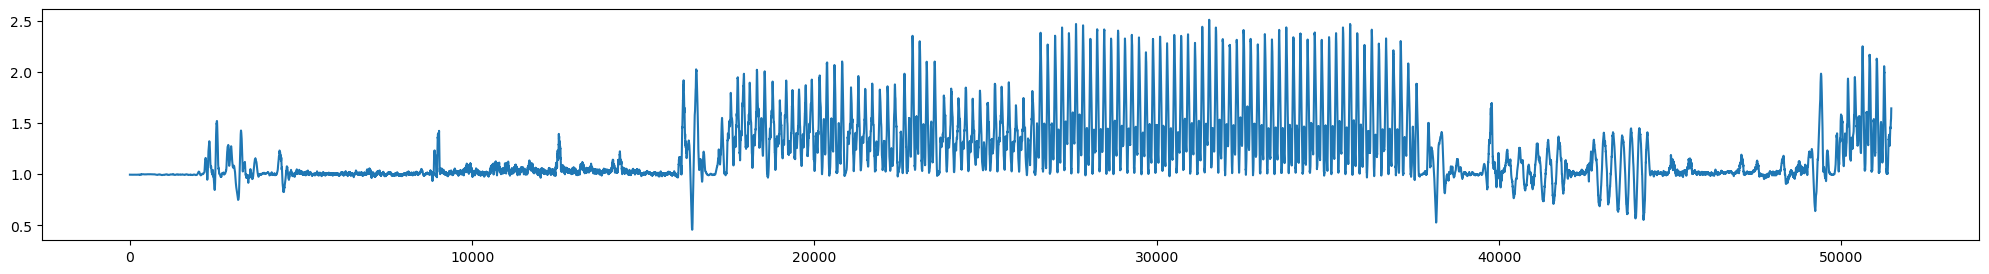

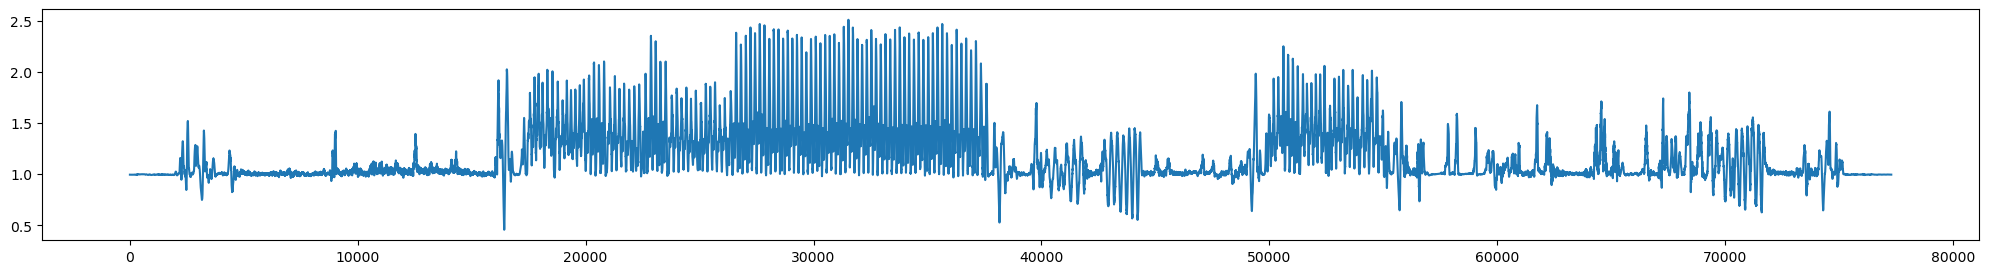

index: 23
{'path_idx': 3, 'activities': [1, 3], 'step_count': 286, 'watch_loc': 1}
pred: 288 
true: 286


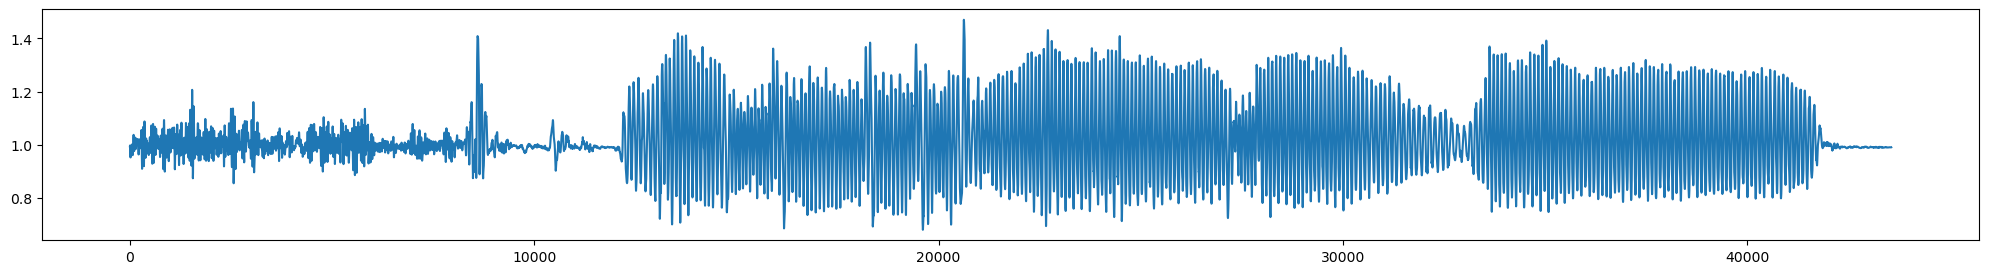

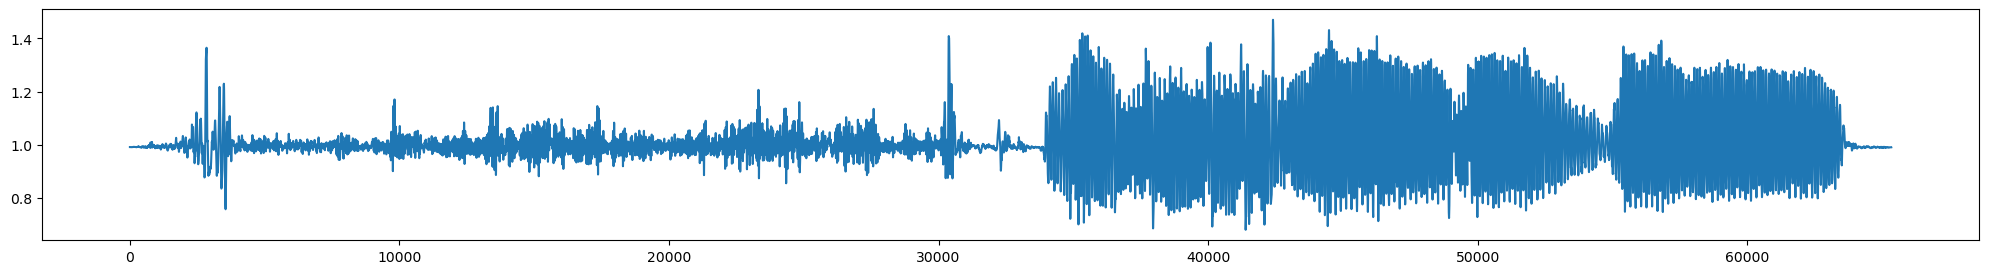

index: 24
{'path_idx': 4, 'activities': [1, 3], 'step_count': 277, 'watch_loc': 0}
pred: 343 
true: 277


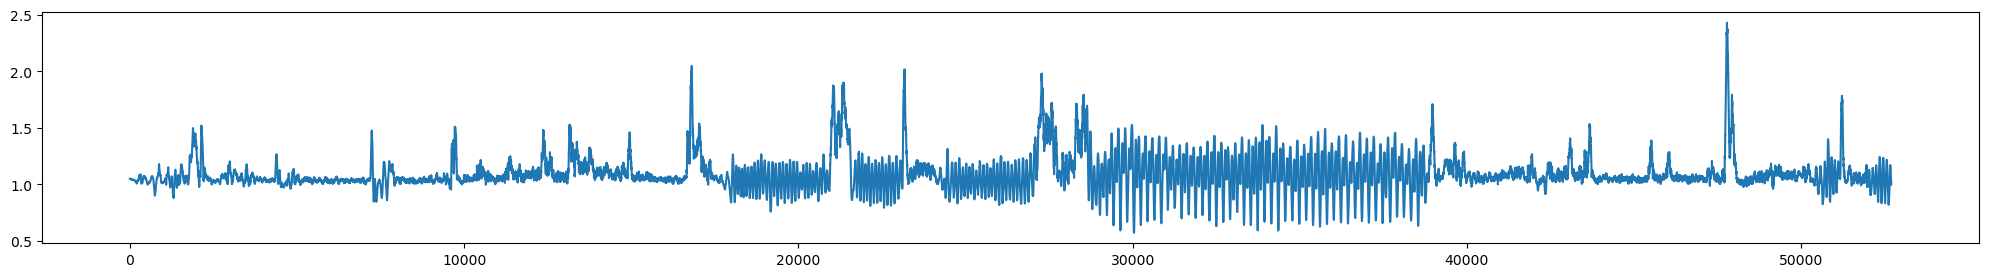

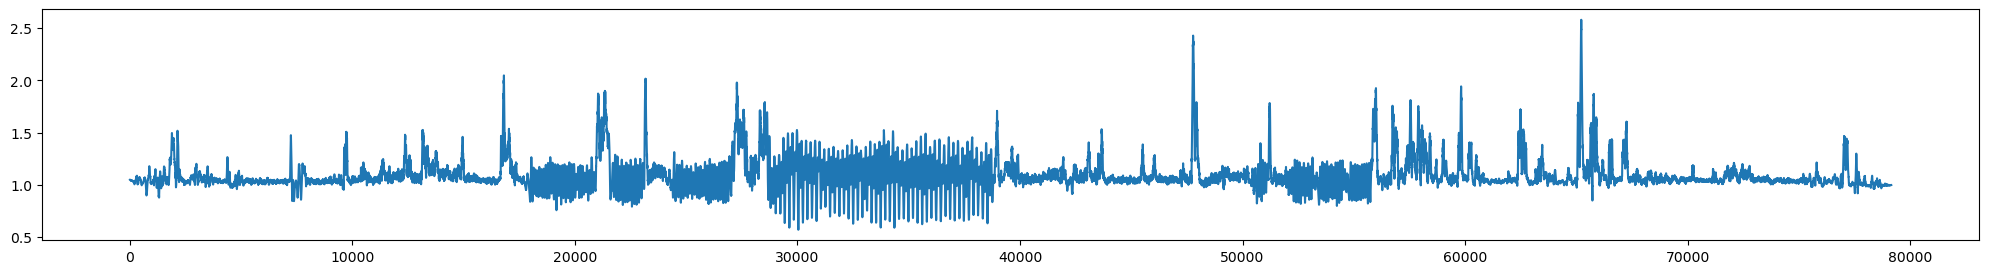

index: 25
{'path_idx': 2, 'activities': [0, 1, 3], 'step_count': 286, 'watch_loc': 2}
pred: 368 
true: 286


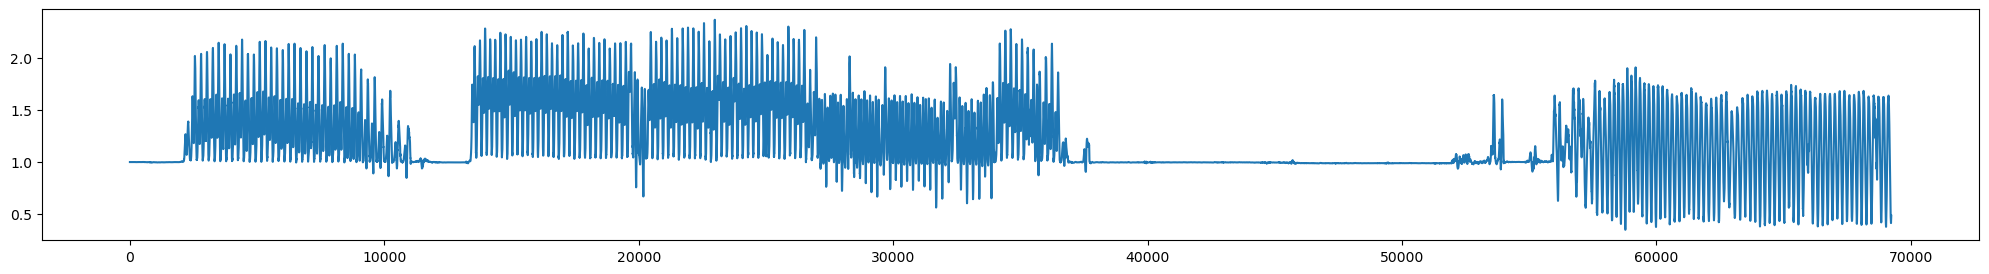

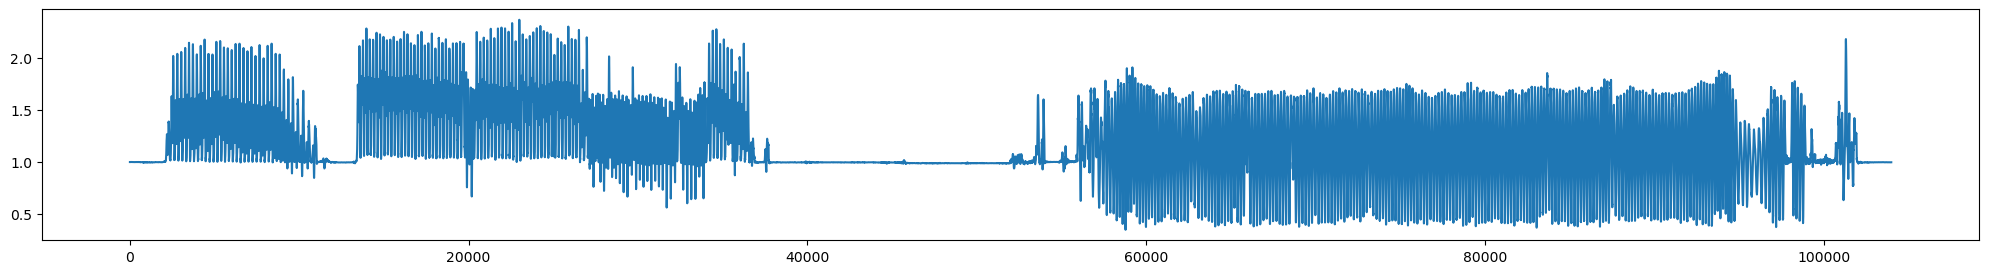

index: 27
{'path_idx': 3, 'activities': [1, 3], 'step_count': 273, 'watch_loc': 2}
pred: 291 
true: 273


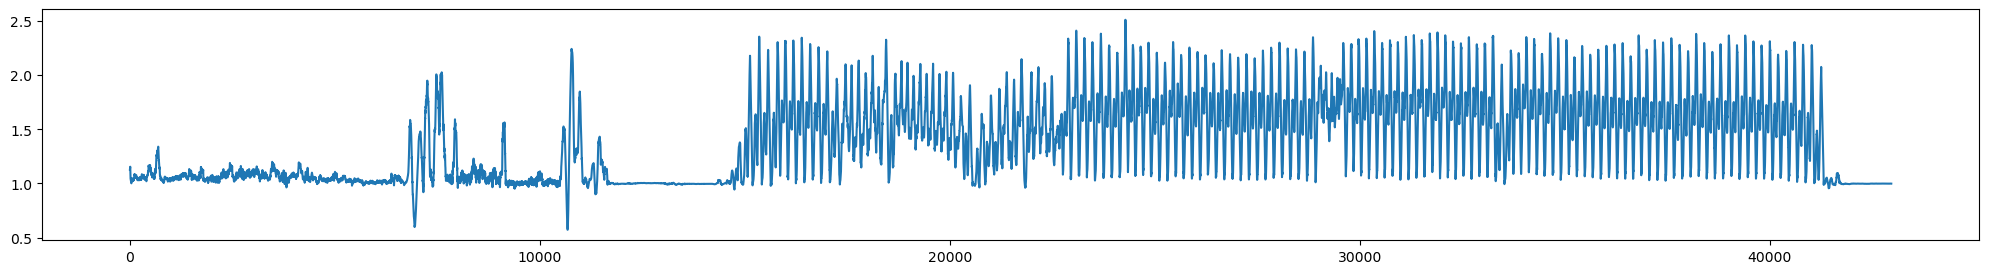

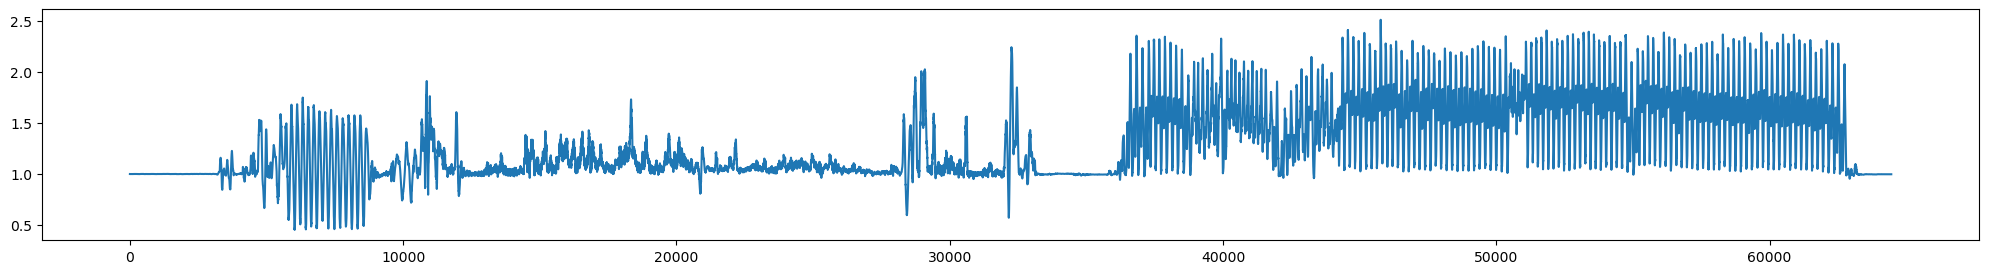

index: 29
{'path_idx': 3, 'activities': [0, 1, 3], 'step_count': 298, 'watch_loc': 2}
pred: 316 
true: 298


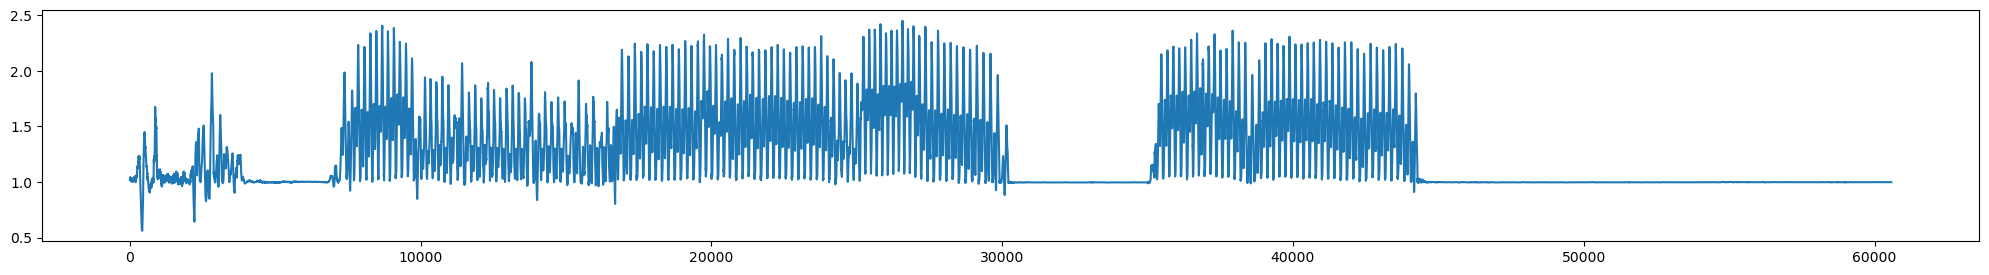

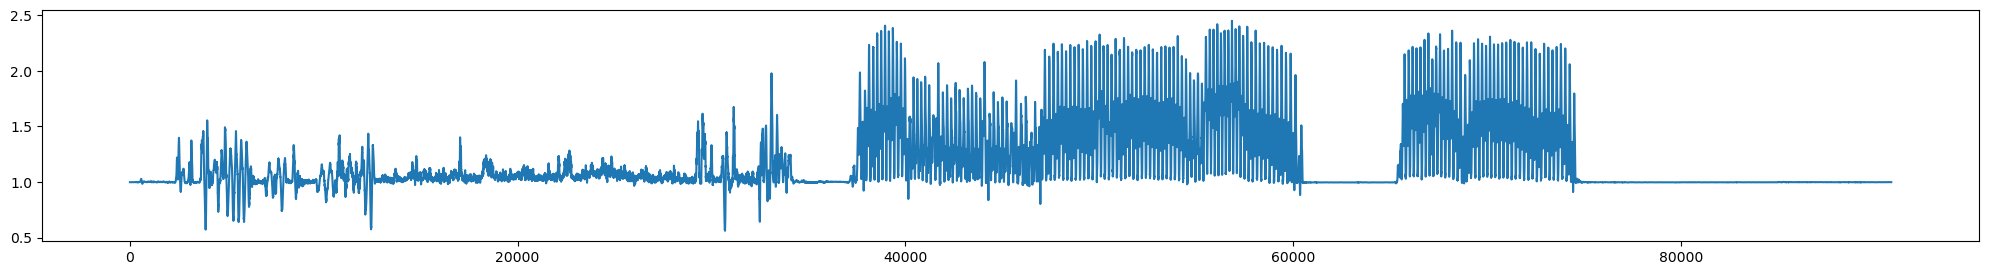

index: 30
{'path_idx': 4, 'activities': [1], 'step_count': 832, 'watch_loc': 0}
pred: 794 
true: 832


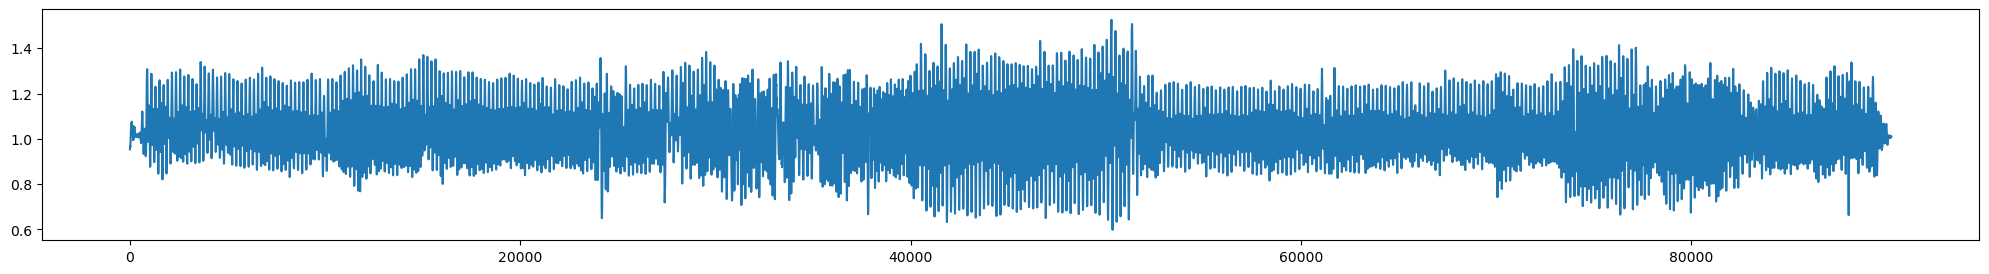

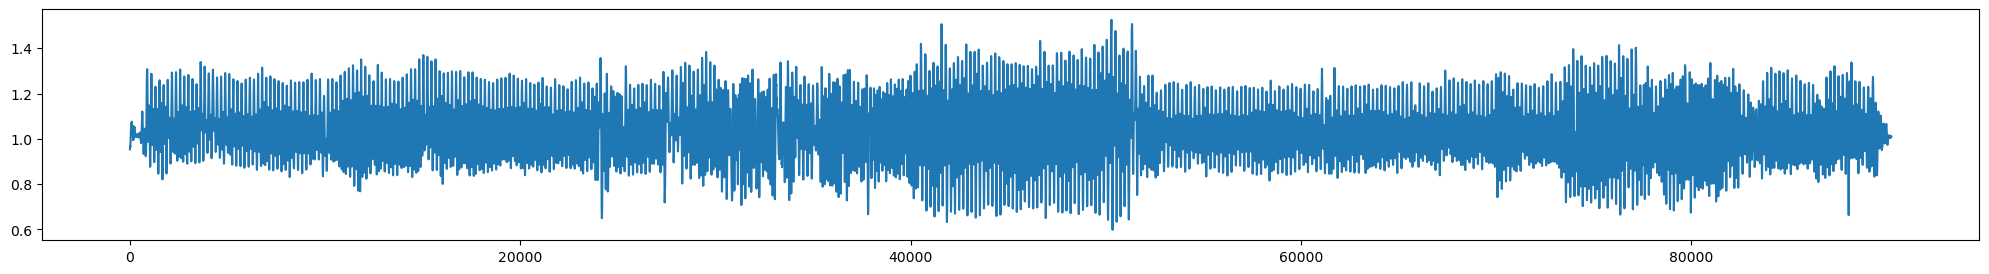

index: 31
{'path_idx': 2, 'activities': [1, 3], 'step_count': 293, 'watch_loc': 0}
pred: 379 
true: 293


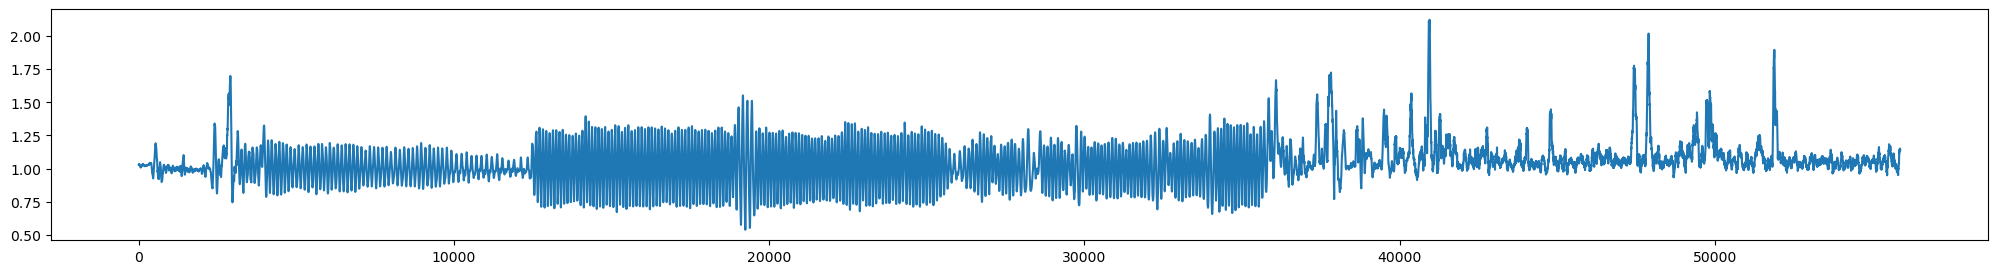

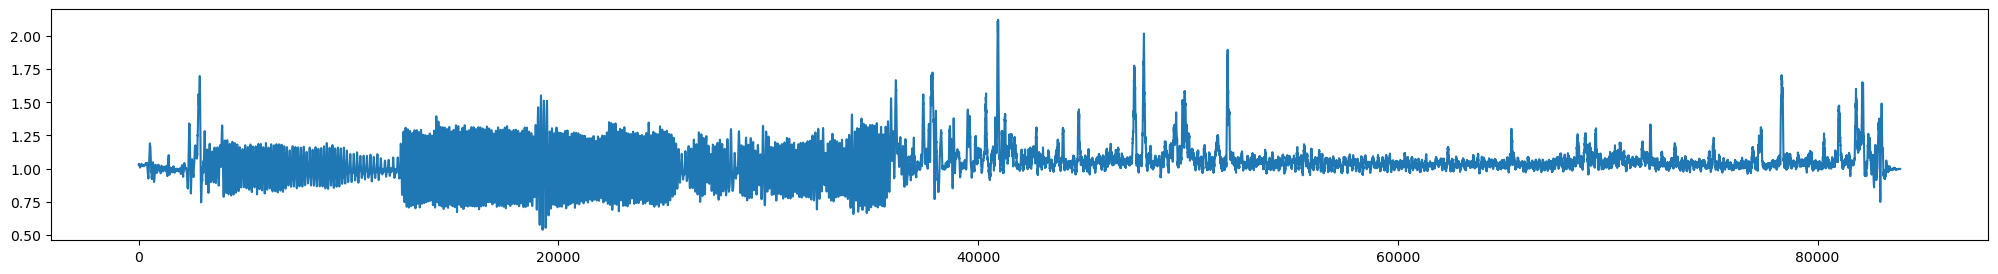

index: 32
{'path_idx': 3, 'activities': [1, 3], 'step_count': 155, 'watch_loc': 0}
pred: 177 
true: 155


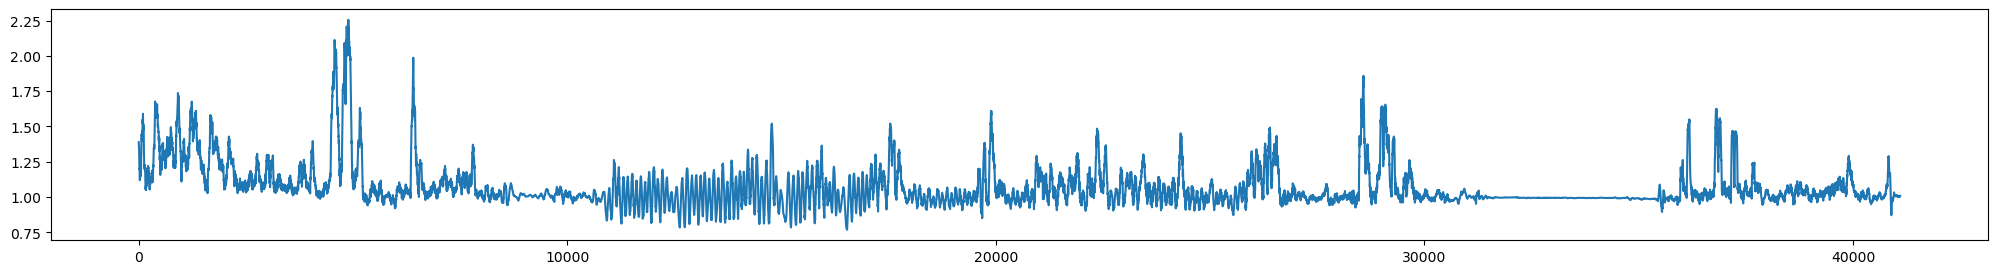

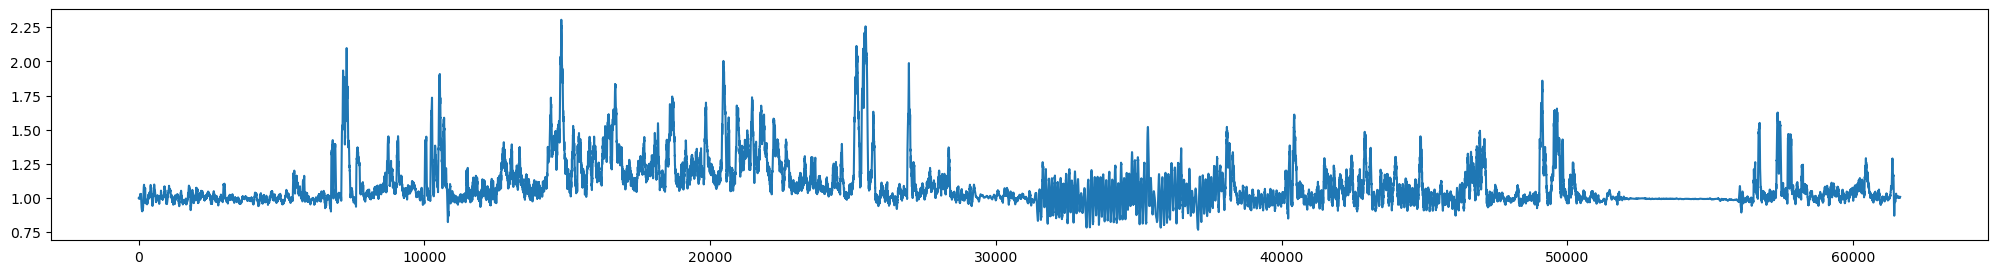

mean diff: 46.107142857142854


In [26]:
diffs = []
for index in range(33):
    #index = 0
    if index in [6,8,12,26,28]:
        continue
    print('index:', index)
    rec = Recording(filenames_train[int(indices[index])])
    print(rec.labels)
    acc_mag = accel_mags_phone[index]
    WINDOW_WATCH=62
    WINDOW_PHONE=23
    window = samp_rates[index]*0.31
    
    cen_mov_avg = centered_moving_average(acc_mag, int(window))
    cen_mov_avg_watch = centered_moving_average(new_data[index], WINDOW_WATCH)
    #peaks = windowed_peak_detection(cen_mov_avg[:40000], 118) #window from paper = 118
    peaks, _ = find_peaks(cen_mov_avg_watch[:], height=1.1, distance=80)#80 for watch, samp_rates[index]//2.5 for phone
    diff = abs(len(peaks) - y[index])
    print('pred:',len(peaks), '\ntrue:', y[index])
    #plot_array(cen_mov_avg[:])
    plot_array(cen_mov_avg_watch[:])
    plot_array(centered_moving_average(accel_mags_watch[index], 62))
    #plot_array(cen_mov_avg[27000:32000])
    #plot_array(cen_mov_avg[40000:45000])
    #break
    diffs.append(diff)
print('mean diff:', np.mean(diffs))

index: 0
{'path_idx': 2, 'activities': [0, 1, 3], 'step_count': 288, 'watch_loc': 2}
pred: 534 
true: 288


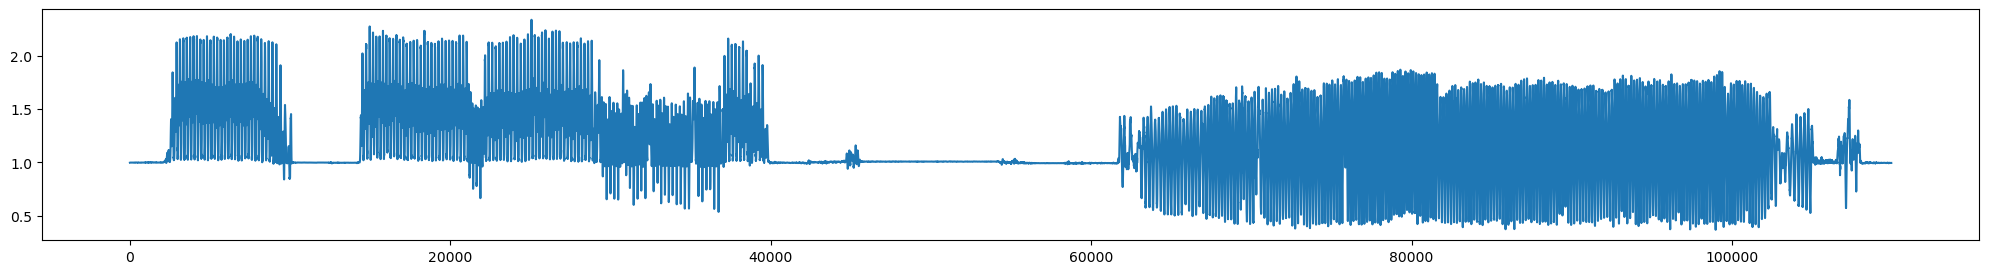

In [20]:
index = 0
print('index:', index)
rec = Recording(filenames_train[int(indices[index])])
print(rec.labels)
acc_mag = accel_mags_phone[index]
WINDOW_WATCH=62
WINDOW_PHONE=23
window = samp_rates[index]*0.31

cen_mov_avg = centered_moving_average(acc_mag, int(window))
cen_mov_avg_watch = centered_moving_average(accel_mags_watch[index], WINDOW_WATCH)
#peaks = windowed_peak_detection(cen_mov_avg[:40000], 118) #window from paper = 118
peaks, _ = find_peaks(cen_mov_avg_watch[:], height=1.1, distance=80)#80 for watch, samp_rates[index]//2.5 for phone
print('pred:',len(peaks), '\ntrue:', y[index])
#plot_array(cen_mov_avg[:])
plot_array(cen_mov_avg_watch[:])
#plot_array(alts[int(indices[index])][100:])
#plot_array(cen_mov_avg[27000:32000])
#plot_array(cen_mov_avg[40000:45000])

proecessed 14 out of 396
proecessed 15 out of 396
proecessed 17 out of 396
proecessed 18 out of 396
proecessed 19 out of 396
proecessed 30 out of 396
proecessed 46 out of 396
proecessed 74 out of 396
proecessed 82 out of 396
proecessed 147 out of 396
proecessed 165 out of 396
proecessed 178 out of 396
proecessed 184 out of 396
proecessed 190 out of 396
proecessed 201 out of 396
proecessed 228 out of 396
proecessed 236 out of 396
proecessed 237 out of 396
proecessed 242 out of 396
proecessed 245 out of 396
proecessed 252 out of 396
proecessed 274 out of 396
proecessed 300 out of 396
proecessed 308 out of 396
proecessed 312 out of 396
proecessed 313 out of 396
proecessed 315 out of 396
proecessed 341 out of 396
proecessed 361 out of 396
proecessed 369 out of 396
proecessed 374 out of 396
proecessed 381 out of 396
proecessed 388 out of 396
Mean absolute error: 281.93939393939394


In [ ]:

'''pd.DataFrame(axs).to_csv('axs.csv')
axs = 0
pd.DataFrame(ays).to_csv('ays.csv')
ays = 0
pd.DataFrame(azs).to_csv('azs.csv')
azs = 0
pd.DataFrame(gxs).to_csv('gxs.csv')
gxs = 0
pd.DataFrame(gys).to_csv('gys.csv')
gys = 0
pd.DataFrame(gzs).to_csv('gzs.csv')
gzs = 0
pd.DataFrame(mxs).to_csv('mxs.csv')
mxs = 0
pd.DataFrame(mys).to_csv('mys.csv')
mys = 0
pd.DataFrame(mzs).to_csv('mzs.csv')
mzs = 0
pd.DataFrame(temps).to_csv('temps.csv')
temps = 0
pd.DataFrame(alts).to_csv('alts.csv')
alts = 0
pd.DataFrame(paxs).to_csv('paxs.csv')
paxs = 0
pd.DataFrame(pays).to_csv('pays.csv')
pays = 0
pd.DataFrame(pazs).to_csv('pazs.csv')
pazs = 0
pd.DataFrame(pgxs).to_csv('pgxs.csv')
pgxs = 0
pd.DataFrame(pgys).to_csv('pgys.csv')
pgys = 0
pd.DataFrame(pgzs).to_csv('pgzs.csv')
pgzs = 0
pd.DataFrame(pmxs).to_csv('pmxs.csv')
pmxs = 0
pd.DataFrame(pmys).to_csv('pmys.csv')
pmys = 0
pd.DataFrame(pmzs).to_csv('pmzs.csv')
pmzs = 0'''

"pd.DataFrame(axs).to_csv('axs.csv')\naxs = 0\npd.DataFrame(ays).to_csv('ays.csv')\nays = 0\npd.DataFrame(azs).to_csv('azs.csv')\nazs = 0\npd.DataFrame(gxs).to_csv('gxs.csv')\ngxs = 0\npd.DataFrame(gys).to_csv('gys.csv')\ngys = 0\npd.DataFrame(gzs).to_csv('gzs.csv')\ngzs = 0\npd.DataFrame(mxs).to_csv('mxs.csv')\nmxs = 0\npd.DataFrame(mys).to_csv('mys.csv')\nmys = 0\npd.DataFrame(mzs).to_csv('mzs.csv')\nmzs = 0\npd.DataFrame(temps).to_csv('temps.csv')\ntemps = 0\npd.DataFrame(alts).to_csv('alts.csv')\nalts = 0\npd.DataFrame(paxs).to_csv('paxs.csv')\npaxs = 0\npd.DataFrame(pays).to_csv('pays.csv')\npays = 0\npd.DataFrame(pazs).to_csv('pazs.csv')\npazs = 0\npd.DataFrame(pgxs).to_csv('pgxs.csv')\npgxs = 0\npd.DataFrame(pgys).to_csv('pgys.csv')\npgys = 0\npd.DataFrame(pgzs).to_csv('pgzs.csv')\npgzs = 0\npd.DataFrame(pmxs).to_csv('pmxs.csv')\npmxs = 0\npd.DataFrame(pmys).to_csv('pmys.csv')\npmys = 0\npd.DataFrame(pmzs).to_csv('pmzs.csv')\npmzs = 0"

In [ ]:
# Loop through all filenames to process recordings
filenames_test = []
submission = []
for filename in filenames_test:
    recording = Recording(filename)
    
    # Assumes filename format ends with a three-digit ID before ".pkl"
    match = re.search(r'(\d{3})\.pkl$', filename)
    if match:
        id = int(match.group(1))
        recording.id = id
    else:
        raise ValueError(f'Filename {filename} does not match expected format')

    # Placeholder for the algorithm to process the recording
    # Implement the logic to infer watch location, path index, step count,
    # and activities (standing, walking, running, cycling) here.
    # Ensure your algorithm is tolerant to missing data and does not crash
    # when optional smartphone data traces are missing.

    path_idx = 0  # Integer, path in {0, 1, 2, 3, 4}
    watch_loc = 0  # Integer, 0: left wrist, 1: belt, 2: right ankle
    standing = False  # Boolean, True if participant was standing still throughout the recording
    walking = False  # Boolean, True if participant was walking throughout the recording
    running = False  # Boolean, True if participant was running throughout the recording
    cycling = False  # Boolean, True if participant was cycling throughout the recording
    step_count = 0  # Integer, number of steps, must be provided for each recording

    predictions = {
        'Id': id, 
        'watch_loc': watch_loc, 
        'path_idx': path_idx,
        'standing': standing,
        'walking': walking,
        'running': running,
        'cycling': cycling,
        'step_count': step_count
        }

    submission.append(predictions)

In [ ]:
# Write the predicted values into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using a text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns of the .csv file ("Id", "watch_loc", "path_idx", "standing", "walking", "running", "cycling", "step_count")
submission_df = pd.DataFrame(submission, columns=['Id', 'watch_loc', 'path_idx', 'standing', 'walking', 'running', 'cycling', 'step_count'])
submission_df.to_csv('submission.csv', index=False)

In [ ]:
X = np.array(pad_arrays(alts))
y = np.array(path_idxs)